Importing notebooks

In [90]:
import pandas as pd
from prophet import Prophet
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from math import sqrt
import xgboost as xgb
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score
from matplotlib.transforms import Bbox

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

%matplotlib inline

# Set seeds to make the experiment more reproducible.
import tensorflow
from numpy.random import seed
tensorflow.random.set_seed(1)
seed(1)

from google.colab import files
uploaded = files.upload()

Saving Load Forecasting Data - 2017-22 (2).csv to Load Forecasting Data - 2017-22 (2) (5).csv


Loading data

In [91]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Load Forecasting Data - 2017-22 (2).csv']))
df.head()

Date   India  Punjab  Haryana  Rajasthan  Delhi     UP
0  01-04-2017  3449.2   127.7    121.1      180.0   83.1  314.9
1  02-04-2017  3303.8   115.3    105.3      178.6   79.5  301.1
2  03-04-2017  3421.6   120.6    118.6      179.3   87.2  313.2
3  04-04-2017  3419.0   109.5    116.6      173.0   84.7  313.2
4  05-04-2017  3362.1    95.0     90.8      174.8   82.3  279.7

# New Section

# New Section

**Machine Learning Models**

In [92]:
df['Date'] = pd.to_datetime(df['Date'],format = "%d-%m-%Y")

df_ind = df[['Date','India']]
df_ind.columns = ['ds','y']
df_ind.set_index("ds",inplace=True)

df_pnb = df[['Date','Punjab']]
df_pnb.columns = ['ds','y']
df_pnb.set_index("ds",inplace=True)

df_hry = df[['Date','Haryana']]
df_hry.columns = ['ds','y']
df_hry.set_index("ds",inplace=True)

df_raj = df[['Date','Rajasthan']]
df_raj.columns = ['ds','y']
df_raj.set_index("ds",inplace=True)

df_del = df[['Date','Delhi']]
df_del.columns = ['ds','y']
df_del.set_index("ds",inplace=True)

df_up = df[['Date','UP']]
df_up.columns = ['ds','y']
df_up.set_index("ds",inplace=True)

In [93]:
class ML_models():
  """
  A class to create a ML time series model
  """

  def __init__(self,data: pd.DataFrame,y_var: str,train_test_split=0):
    self.df = data
    self.y_var = y_var
    self.result = dict()
    self.predictions = dict()
    self.reg_list = []
    self.y_t=[]

  def full_extent(self,ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels()
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

  def create_features_datetime(self):

    self.df['year']=self.df.index.year
    self.df['month']=self.df.index.month
    self.df['day_of_week']=self.df.index.day_of_week

  def add_lag(self,lag):
    self.df[f'lag_'+str(lag)]=self.df[self.y_var].shift(lag)
    self.df.dropna(inplace=True)

  def plot_corr(self,fig_name,lags=50):
    lagger=lags
    fig, ax = plt.subplots(figsize=(12,5))
    fig1, ax1 = plt.subplots(figsize=(12,5))

    _=plot_acf(x=self.df[self.y_var],ax=ax,lags=lagger)
    fig.savefig(str(fig_name+"ACF.jpg"))
    _=plot_pacf(x=self.df[self.y_var],method='ols',ax=ax1,lags=lagger)
    fig1.savefig(str(fig_name+"PACF.jpg"))

  def plotter(self,fig_name):
    res = seasonal_decompose(x=self.df[self.y_var].values,period=365)
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid


    plt.figure(figsize=(12,8))

    plt.subplot(411)
    plt.plot(self.df.index,self.df[self.y_var],label="Orginal",color='red')
    plt.legend(loc='upper left')

    plt.subplot(412)
    plt.plot(self.df.index,trend,label="Trend",color='red')
    plt.legend(loc='upper left')

    plt.subplot(413)
    plt.plot(self.df.index,seasonal,label="Seasonal",color='red')
    plt.legend(loc='upper left')

    plt.subplot(414)
    plt.plot(self.df.index,residual,label="Residual",color='red')
    plt.legend(loc='upper left')

    plt.savefig(fig_name)
    plt.show()

  def train(self):
    self.create_features_datetime()
    x=self.df.drop([self.y_var],axis=1)
    y=self.df[[self.y_var]]
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,shuffle=False)
    self.y_t = y_test

    reg_1=LinearRegression(n_jobs=-1)
    reg_2=XGBRegressor(n_estimators=500)
    reg_3=RandomForestRegressor(n_estimators=500,n_jobs=-1)
    reg_4=DecisionTreeRegressor()

    self.reg_list=[reg_1,reg_2,reg_3,reg_4]

    print("-"*50)
    for reg in self.reg_list:
      reg_name=reg.__class__.__name__
      reg.fit(x_train,y_train.values.ravel())
      print(f"Fitting {reg_name} done")
      print("-"*50)

    for reg in self.reg_list:
      reg_name = reg.__class__.__name__
      pred=reg.predict(x_test)
      self.predictions[reg_name] = pred

      self.result[reg_name]={
          "R2 Score":r2_score(y_test,pred),
          "Mean Absolute Error Score":mean_absolute_error(y_test,pred),
          "Mean Squared Error Score":mean_squared_error(y_test,pred),
          "Root Mean Squared Error": mean_squared_error(y_test,pred, squared=False)
      }
      self.show_result()

  def show_result(self):
    score=pd.DataFrame(self.result).transpose().sort_values("R2 Score",ascending=False)
    return score

  def plot_predictions(self,fig_name):
    plt.figure(figsize=(12,8))

    i = 0
    fig,ax=plt.subplots(4,1,figsize=(20,16))
    fig.tight_layout(h_pad=3, w_pad=1)
    for reg in self.reg_list:
      reg_name = reg.__class__.__name__
      s = str(fig_name+reg_name+".jpg")
      pred=self.predictions[reg_name]
      sns.lineplot(data=self.y_t,ax=ax[i],legend='brief')
      sns.lineplot(y=pred,x=self.y_t.index,ax=ax[i],legend="brief",label="predicted")
      ax[i].set_title(reg_name)
      extent = self.full_extent(ax[i]).transformed(fig.dpi_scale_trans.inverted())
      fig.savefig(s, bbox_inches=extent)
      i+=1
    plt.show()


In [94]:
indML = ML_models(df_ind,'y',0.2)
pnbML = ML_models(df_pnb,'y',0.2)
hryML = ML_models(df_hry,'y',0.2)
rajML = ML_models(df_raj,'y',0.2)
delML = ML_models(df_del,'y',0.2)
upML = ML_models(df_up,'y',0.2)

ML models on All India Data

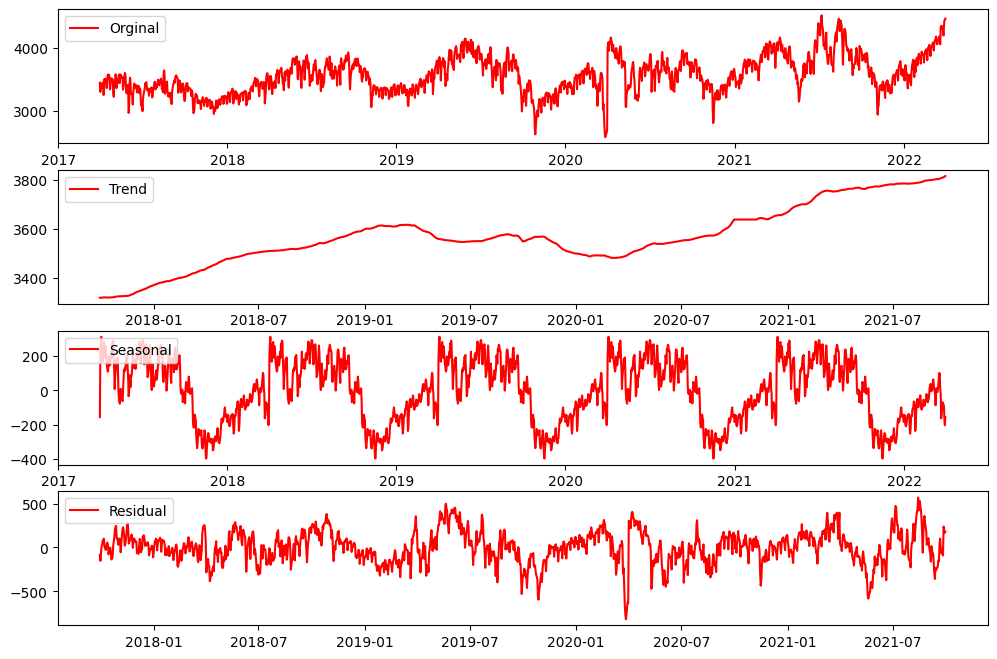

In [95]:
indML.plotter("indiaSD.jpg")

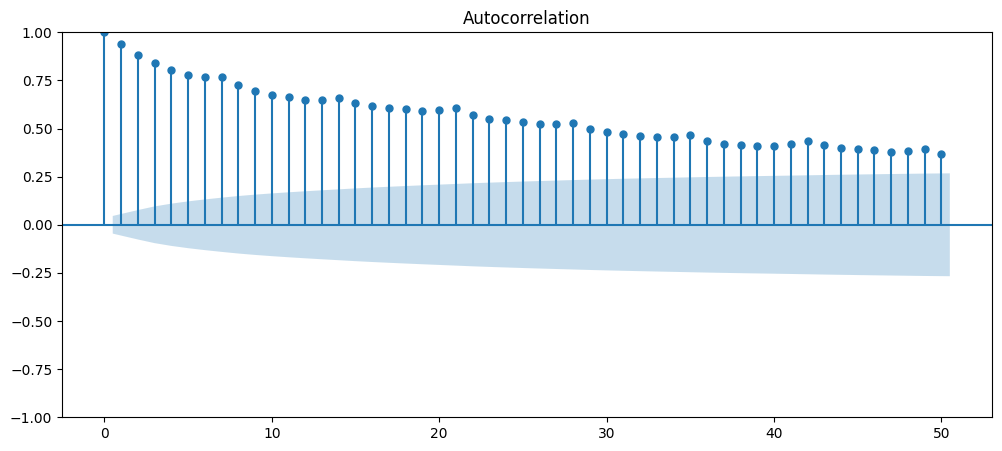

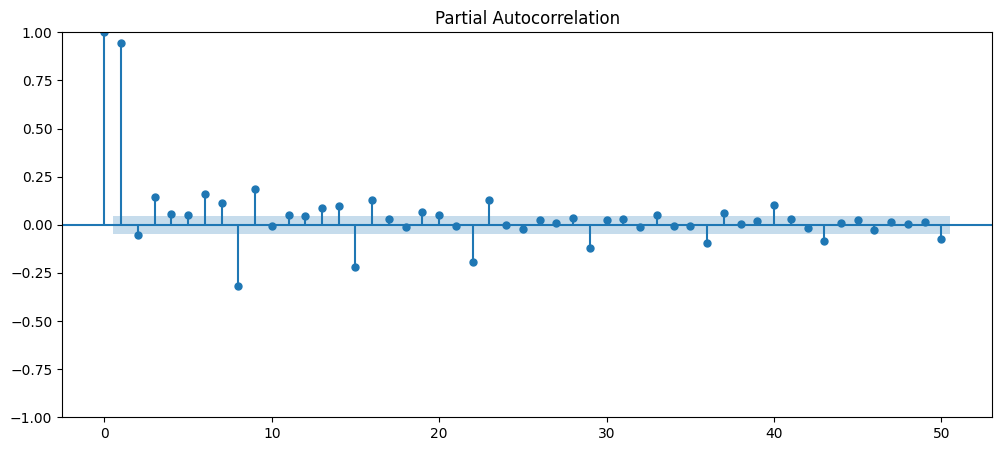

In [96]:
indML.plot_corr("ind")

In [97]:
indML.add_lag(1)
indML.add_lag(8)

<ipython-input-93-f352f3d1ff34>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[f'lag_'+str(lag)]=self.df[self.y_var].shift(lag)
<ipython-input-93-f352f3d1ff34>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.dropna(inplace=True)
<ipython-input-93-f352f3d1ff34>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [98]:
indML.train()

<ipython-input-93-f352f3d1ff34>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['year']=self.df.index.year
<ipython-input-93-f352f3d1ff34>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['month']=self.df.index.month
<ipython-input-93-f352f3d1ff34>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

--------------------------------------------------
Fitting LinearRegression done
--------------------------------------------------
Fitting XGBRegressor done
--------------------------------------------------
Fitting RandomForestRegressor done
--------------------------------------------------
Fitting DecisionTreeRegressor done
--------------------------------------------------


In [99]:
indML.show_result()

R2 Score  Mean Absolute Error Score  \
LinearRegression       0.932396                  58.599883   
RandomForestRegressor  0.832370                  82.677737   
XGBRegressor           0.776371                  93.025848   
DecisionTreeRegressor  0.732167                 103.545879   

                       Mean Squared Error Score  Root Mean Squared Error  
LinearRegression                    5966.724415                77.244575  
RandomForestRegressor              14795.024935               121.634801  
XGBRegressor                       19737.506090               140.490235  
DecisionTreeRegressor              23638.937940               153.749595

<Figure size 1200x800 with 0 Axes>

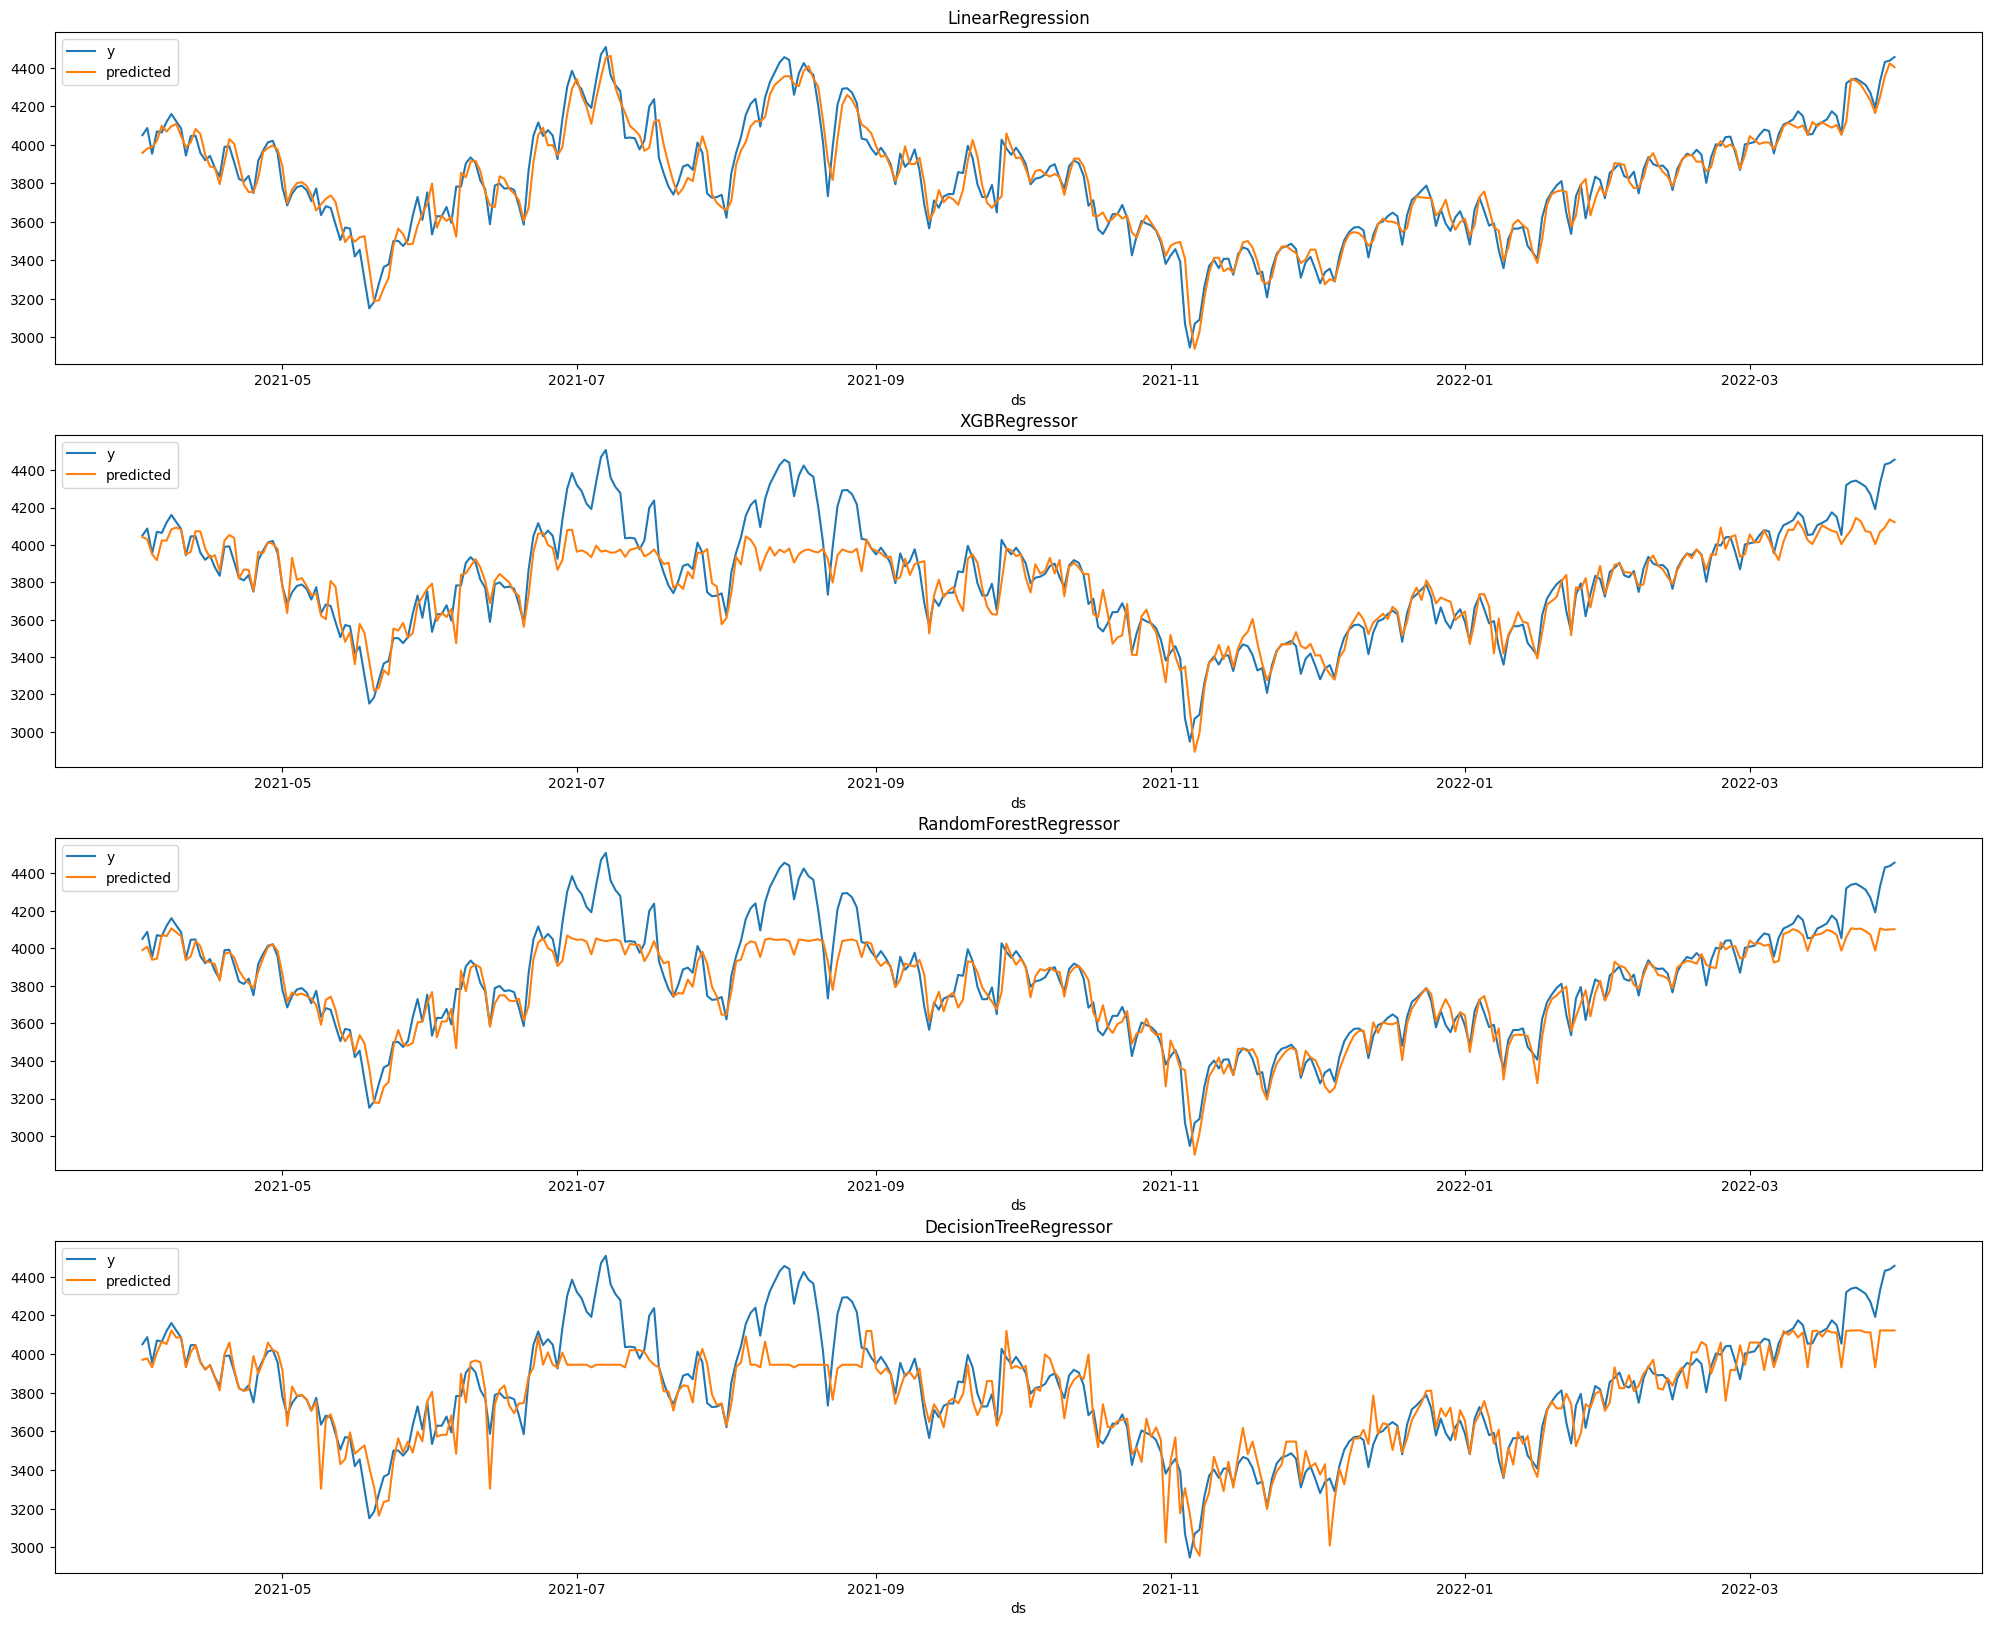

In [100]:
indML.plot_predictions("indML")

ML Models on Punjab Data





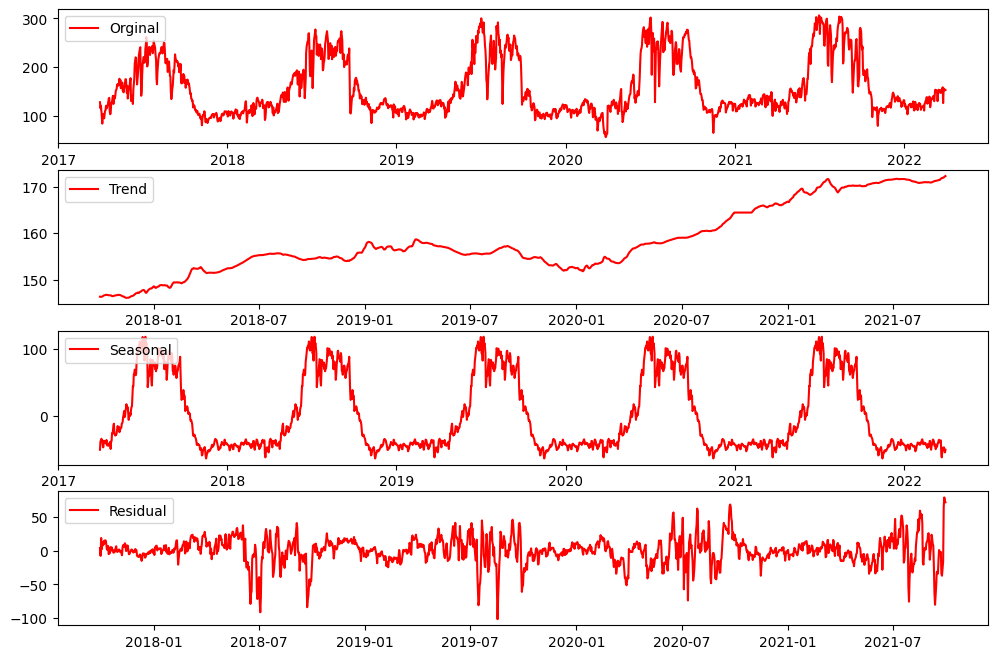

In [101]:
pnbML.plotter("pnbSD.jpg")

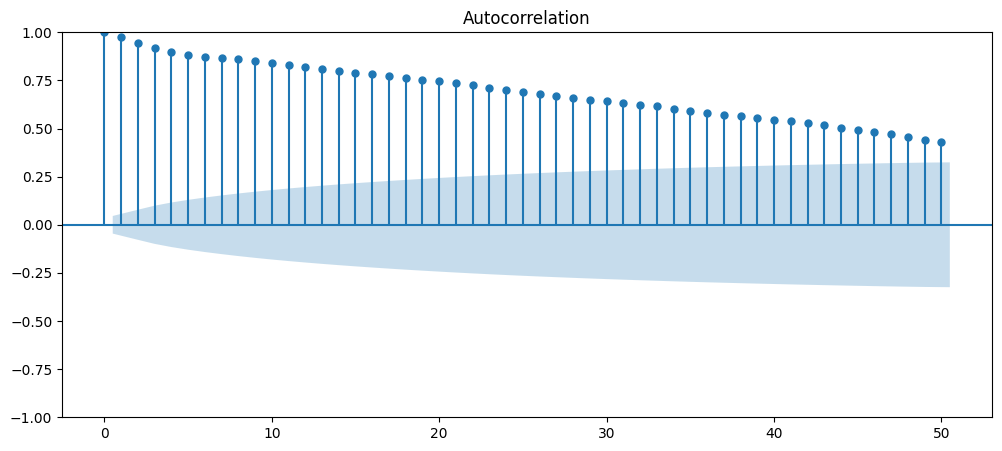

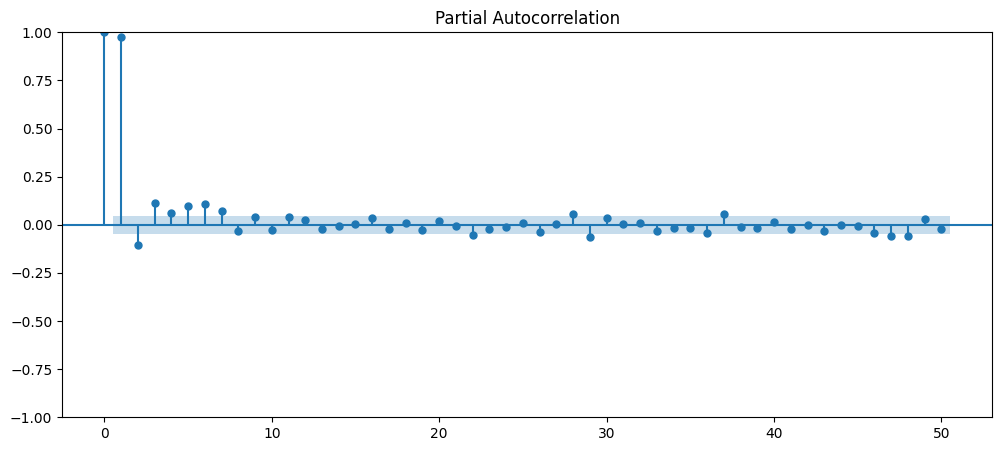

In [102]:
pnbML.plot_corr("pnb")

In [103]:
pnbML.add_lag(1)
pnbML.train()

<ipython-input-93-f352f3d1ff34>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[f'lag_'+str(lag)]=self.df[self.y_var].shift(lag)
<ipython-input-93-f352f3d1ff34>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.dropna(inplace=True)
<ipython-input-93-f352f3d1ff34>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

--------------------------------------------------
Fitting LinearRegression done
--------------------------------------------------
Fitting XGBRegressor done
--------------------------------------------------
Fitting RandomForestRegressor done
--------------------------------------------------
Fitting DecisionTreeRegressor done
--------------------------------------------------


In [104]:
pnbML.show_result()

R2 Score  Mean Absolute Error Score  \
LinearRegression       0.948509                   8.631281   
RandomForestRegressor  0.935404                  10.193586   
XGBRegressor           0.923856                  11.450850   
DecisionTreeRegressor  0.897425                  12.995068   

                       Mean Squared Error Score  Root Mean Squared Error  
LinearRegression                     202.263746                14.221946  
RandomForestRegressor                253.742497                15.929297  
XGBRegressor                         299.103647                17.294613  
DecisionTreeRegressor                402.927890                20.073064

<Figure size 1200x800 with 0 Axes>

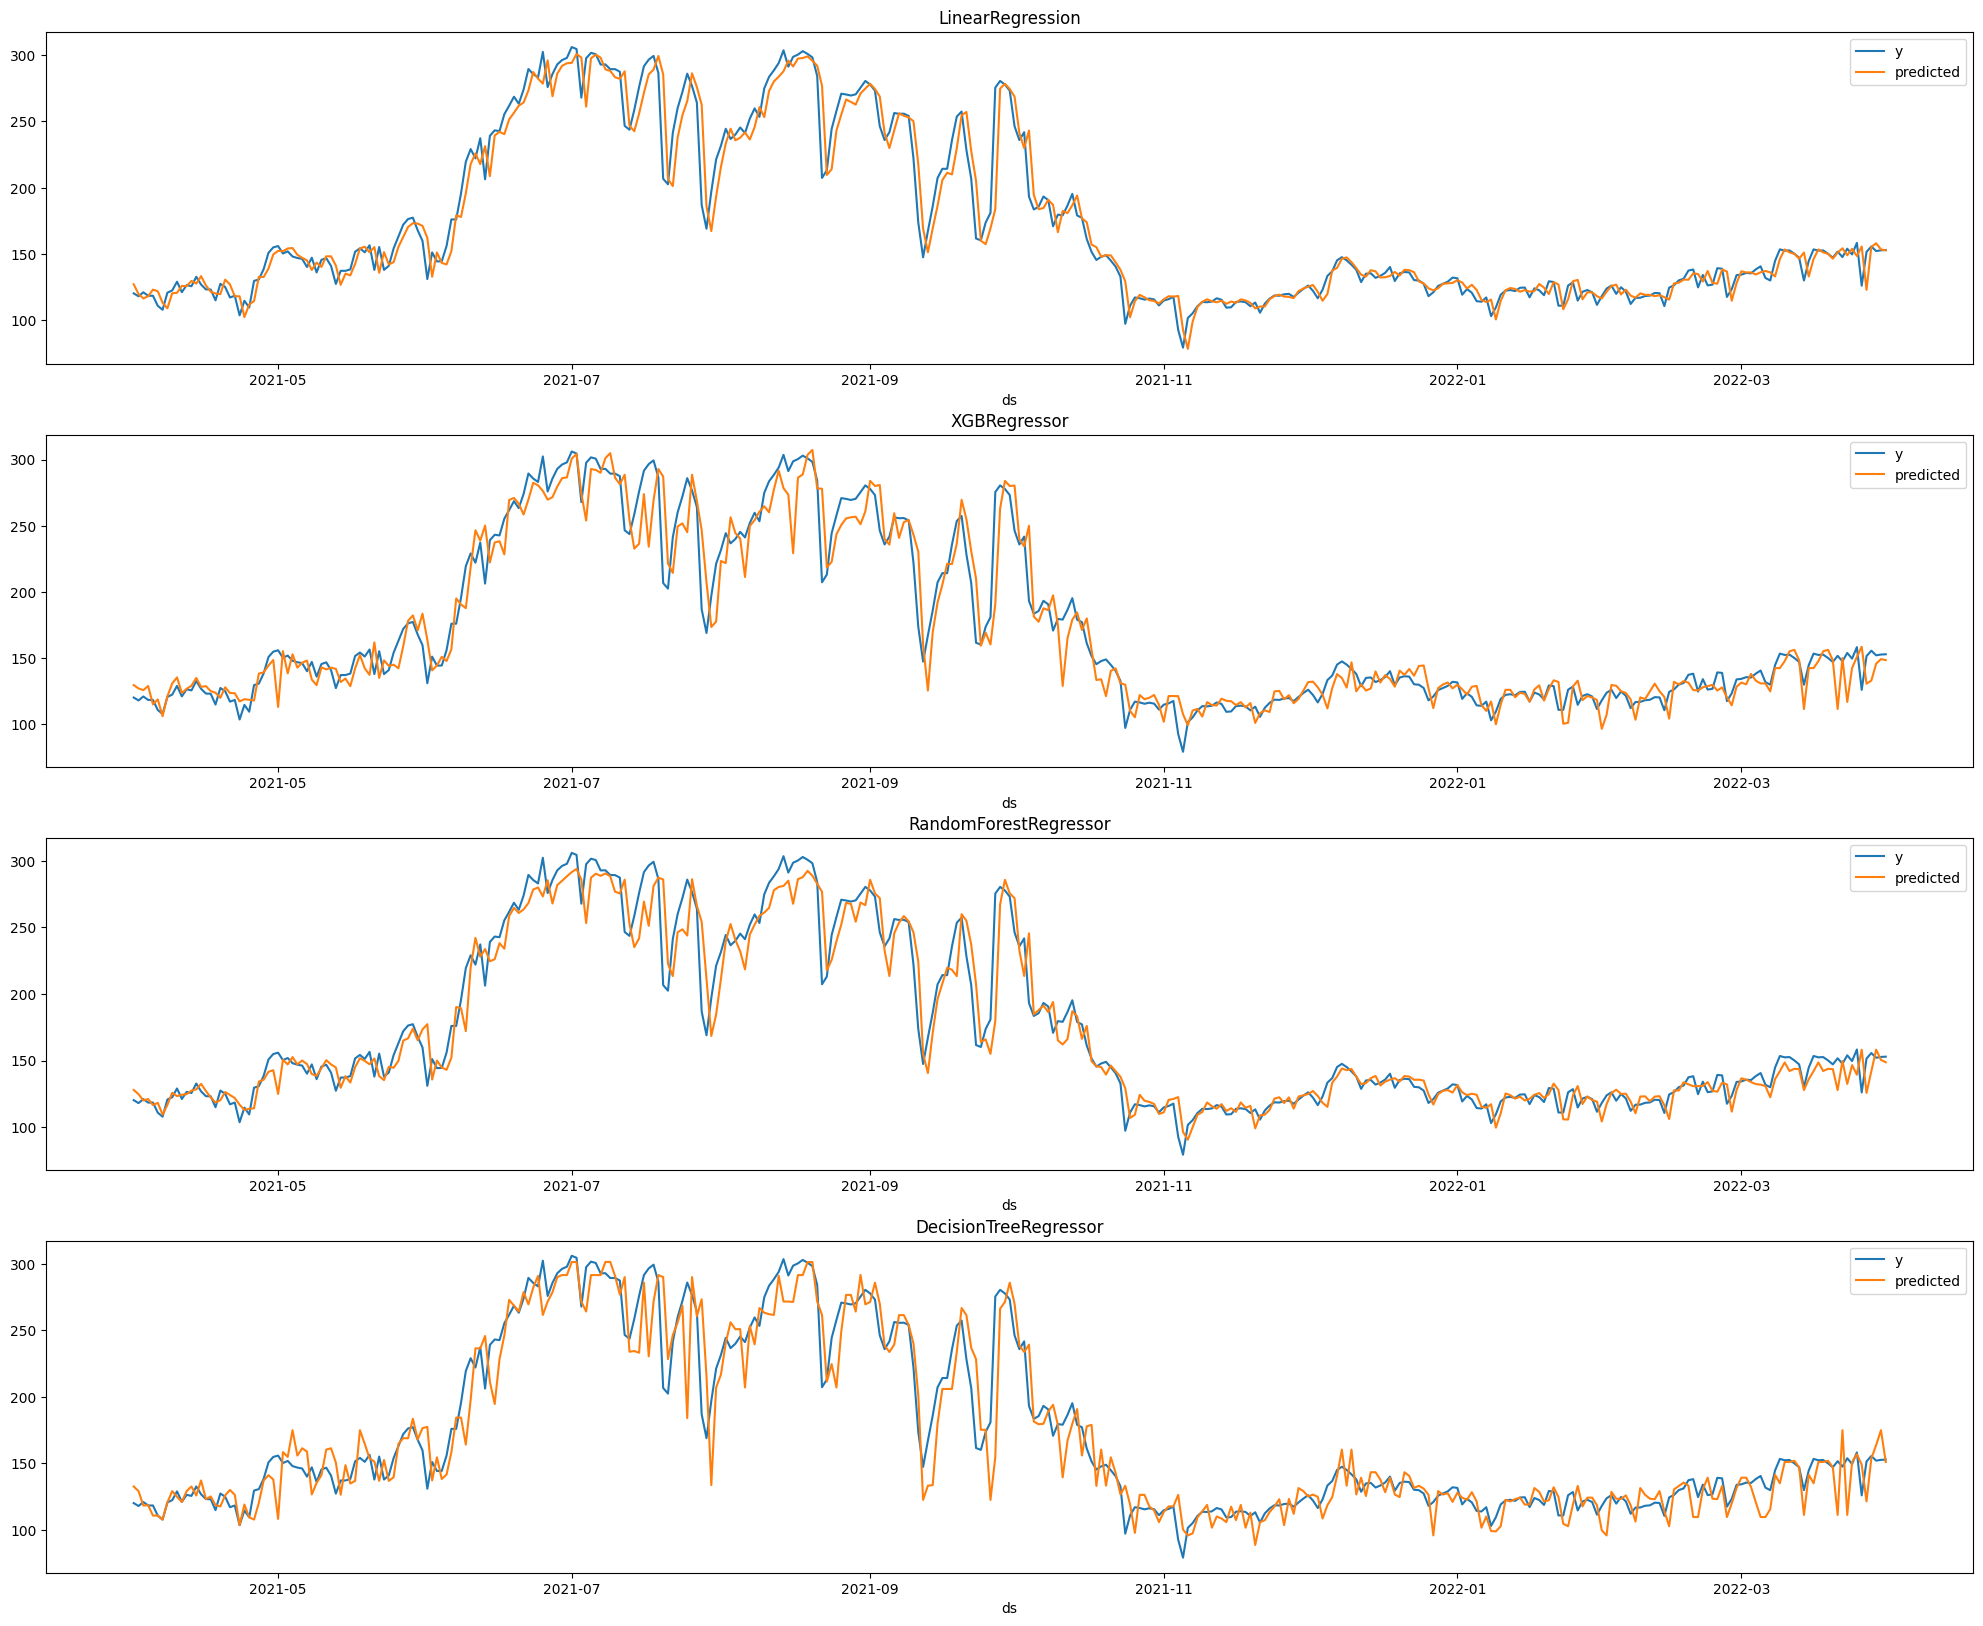

In [105]:
pnbML.plot_predictions("pnbML")

ML models on Haryana Data

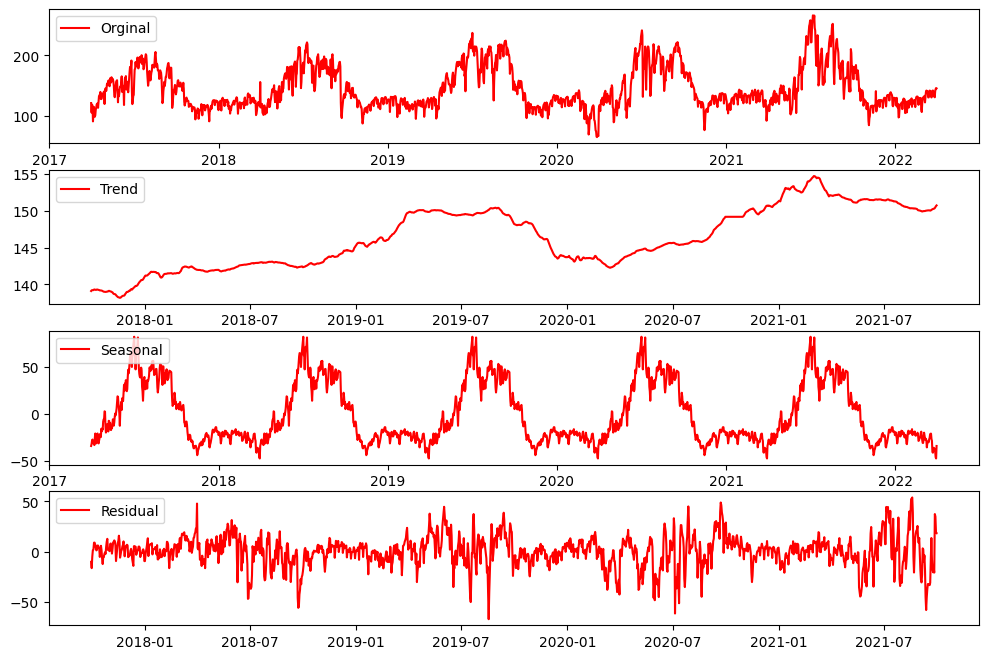

In [106]:
hryML.plotter("hrySD.jpg")

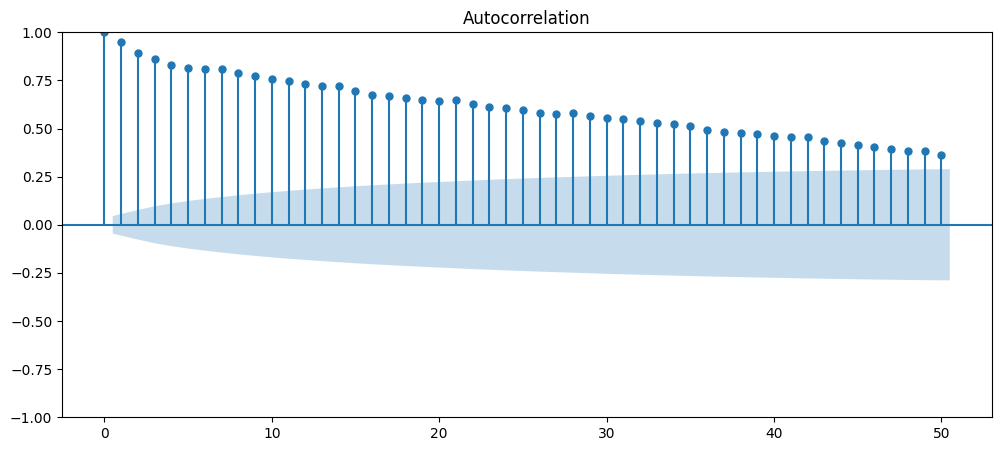

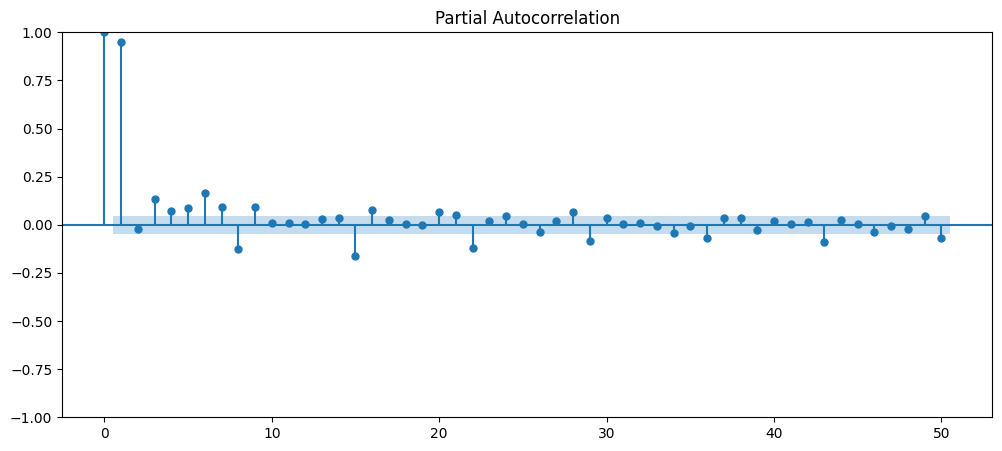

In [107]:
hryML.plot_corr("hry")

In [108]:
hryML.add_lag(1)
hryML.train()

<ipython-input-93-f352f3d1ff34>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[f'lag_'+str(lag)]=self.df[self.y_var].shift(lag)
<ipython-input-93-f352f3d1ff34>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.dropna(inplace=True)
<ipython-input-93-f352f3d1ff34>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

--------------------------------------------------
Fitting LinearRegression done
--------------------------------------------------
Fitting XGBRegressor done
--------------------------------------------------
Fitting RandomForestRegressor done
--------------------------------------------------
Fitting DecisionTreeRegressor done
--------------------------------------------------


In [109]:
hryML.show_result()

R2 Score  Mean Absolute Error Score  \
LinearRegression       0.909746                   7.660772   
RandomForestRegressor  0.876193                   8.666964   
XGBRegressor           0.848321                   9.319586   
DecisionTreeRegressor  0.782754                  11.173973   

                       Mean Squared Error Score  Root Mean Squared Error  
LinearRegression                     135.433806                11.637603  
RandomForestRegressor                185.782609                13.630209  
XGBRegressor                         227.607353                15.086661  
DecisionTreeRegressor                325.995918                18.055357

<Figure size 1200x800 with 0 Axes>

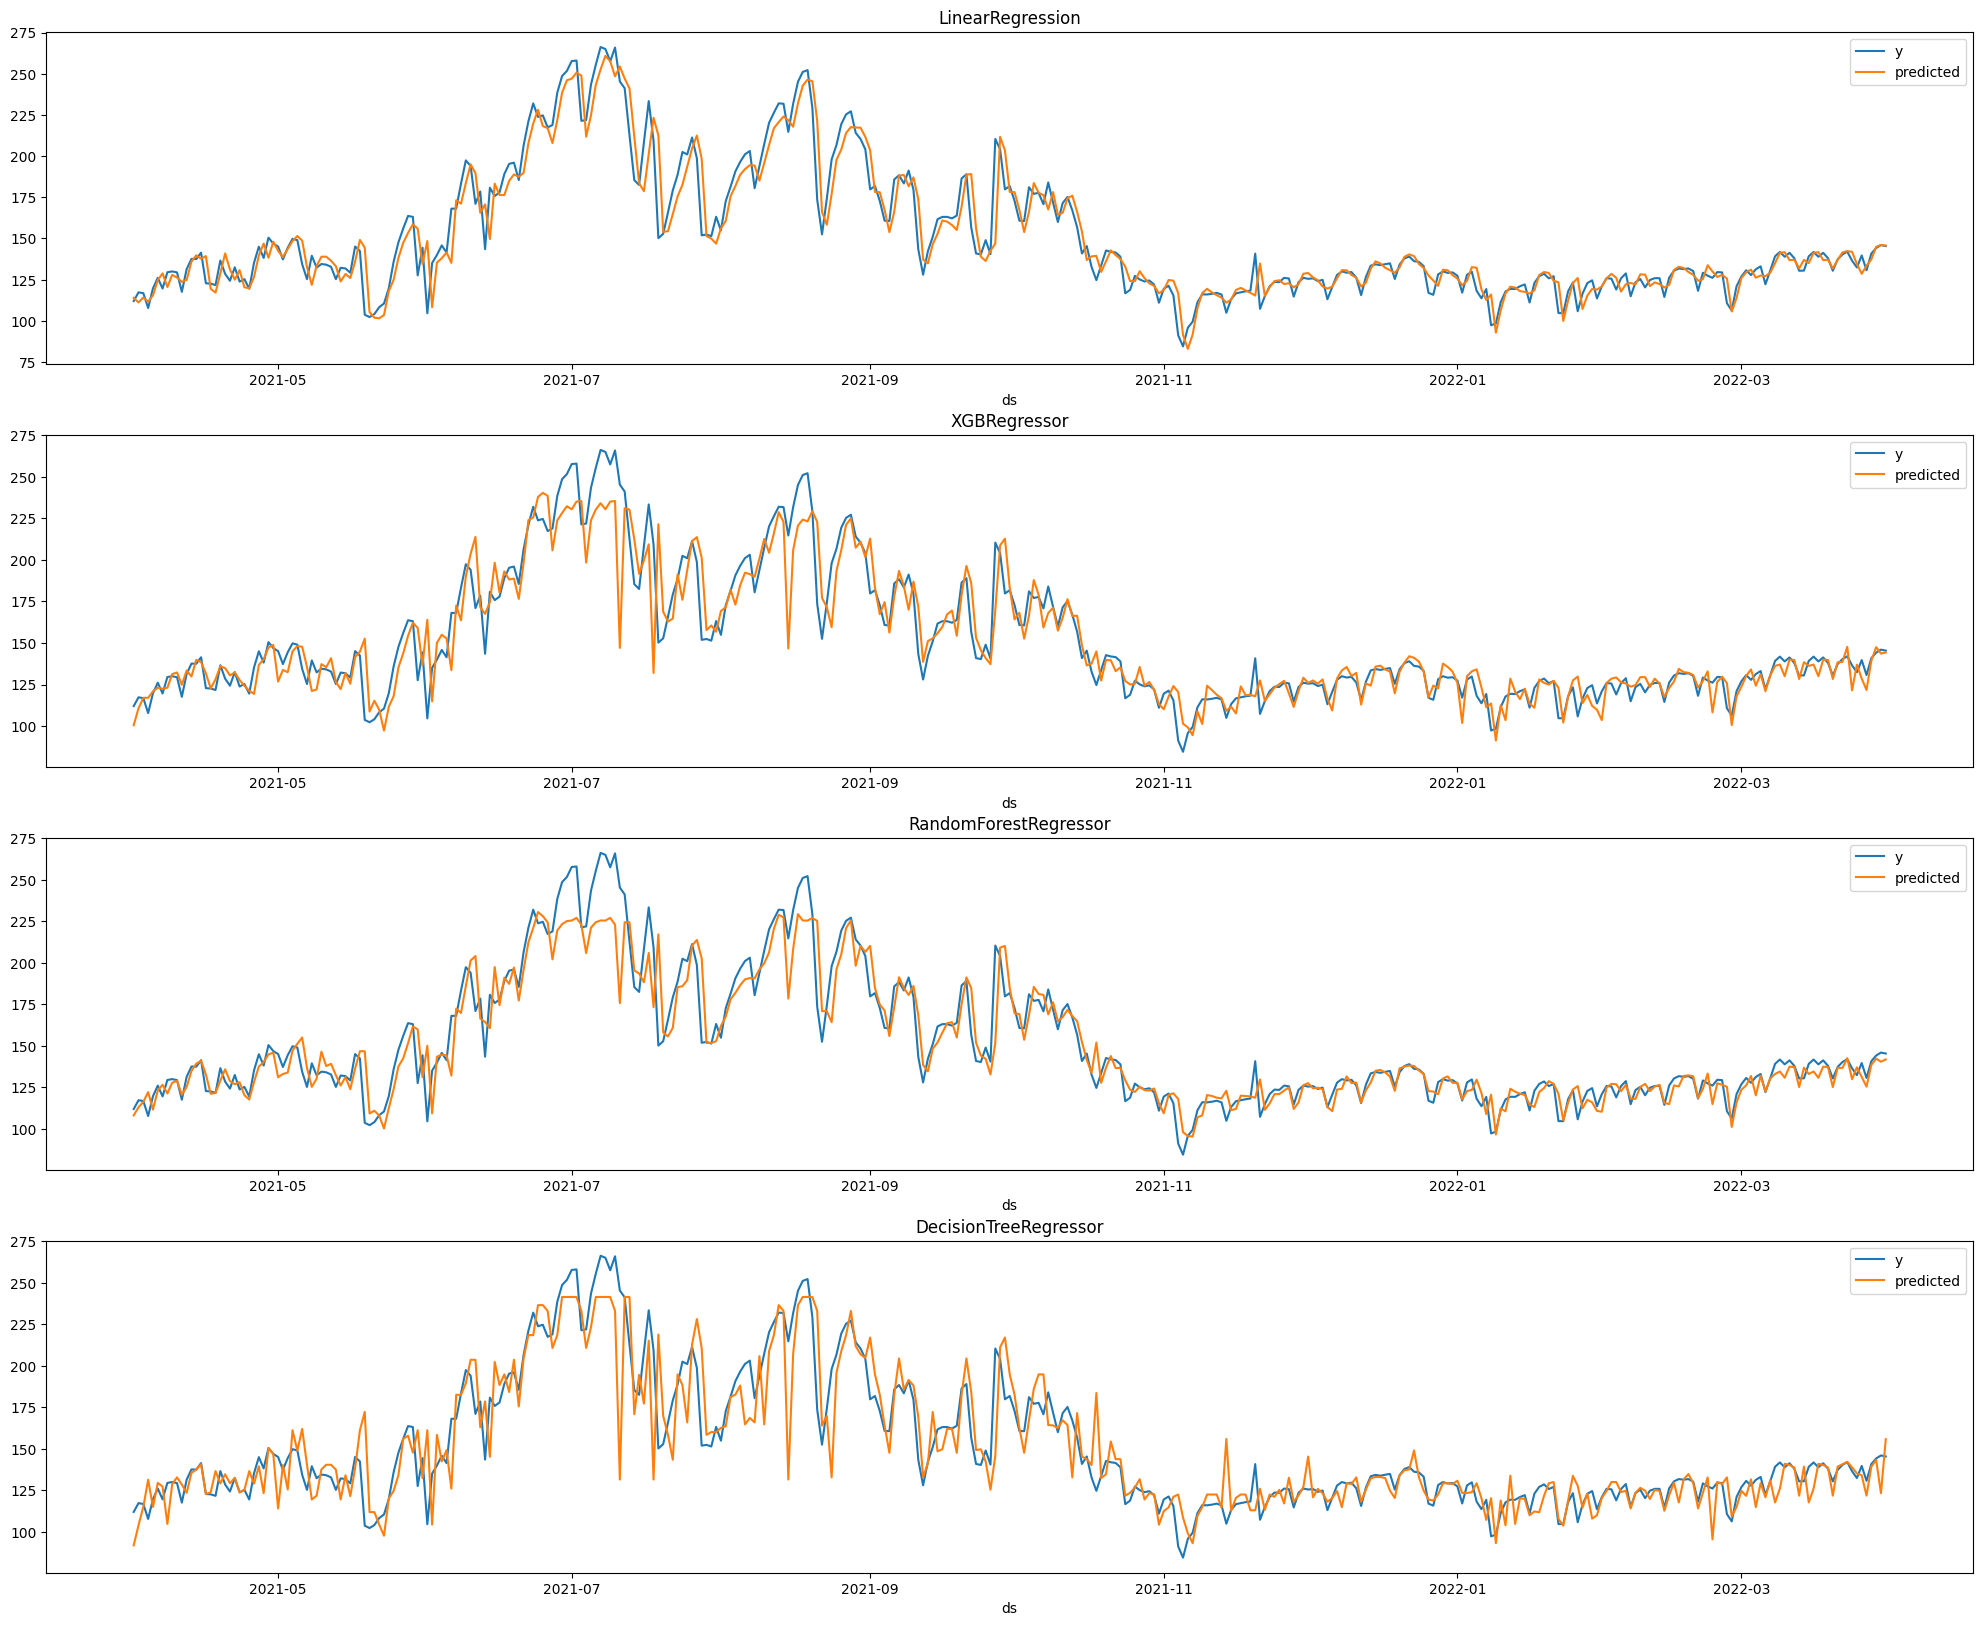

In [110]:
hryML.plot_predictions("hryML")

ML models on Rajasthan Data

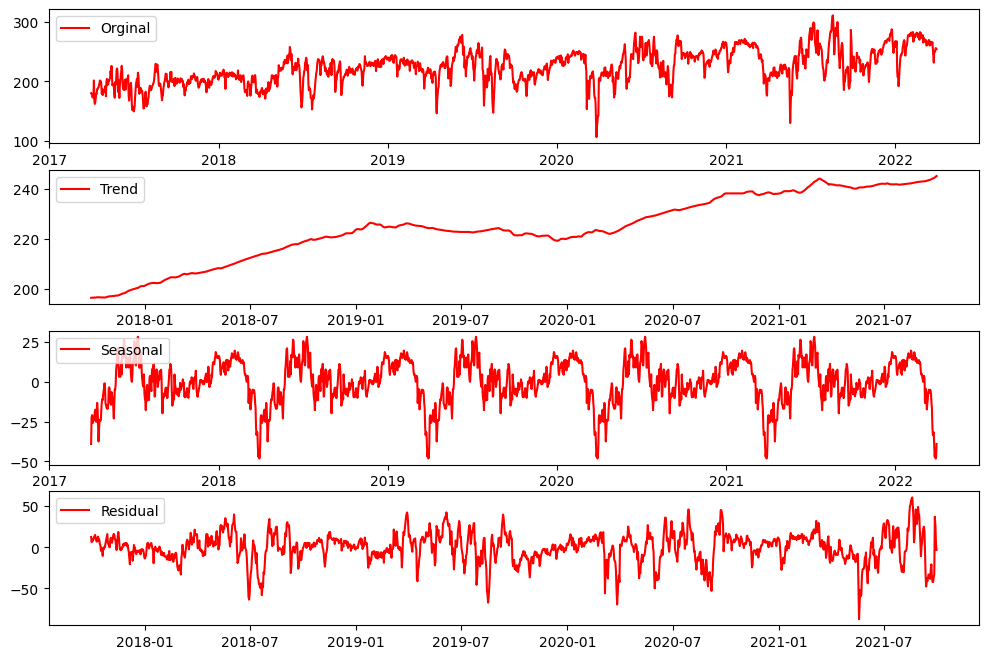

In [111]:
rajML.plotter("rajSD.jpg")

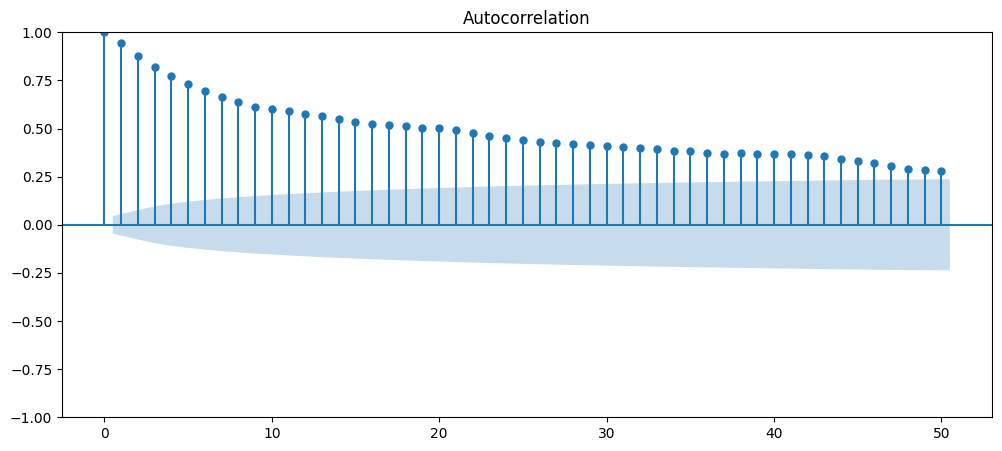

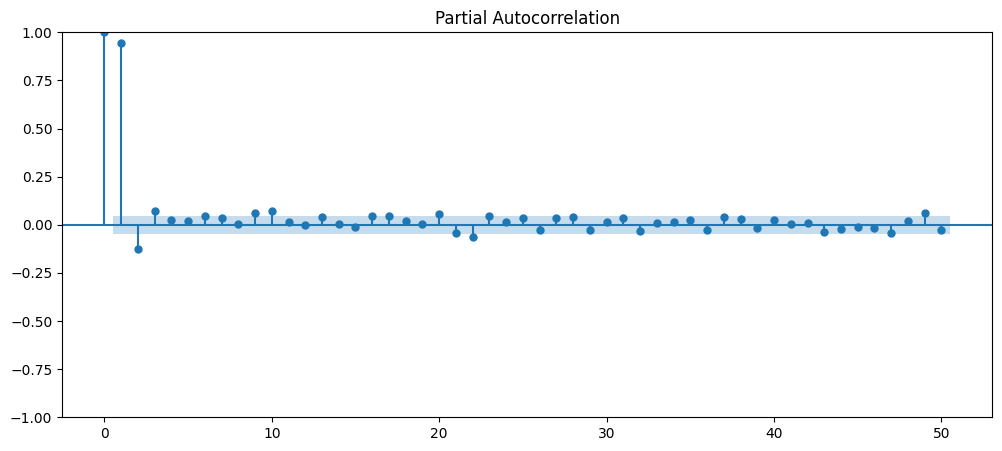

In [112]:
rajML.plot_corr("raj")

In [113]:
rajML.add_lag(1)

<ipython-input-93-f352f3d1ff34>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[f'lag_'+str(lag)]=self.df[self.y_var].shift(lag)
<ipython-input-93-f352f3d1ff34>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.dropna(inplace=True)


In [114]:
rajML.train()

<ipython-input-93-f352f3d1ff34>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['year']=self.df.index.year
<ipython-input-93-f352f3d1ff34>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['month']=self.df.index.month
<ipython-input-93-f352f3d1ff34>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

--------------------------------------------------
Fitting LinearRegression done
--------------------------------------------------
Fitting XGBRegressor done
--------------------------------------------------
Fitting RandomForestRegressor done
--------------------------------------------------
Fitting DecisionTreeRegressor done
--------------------------------------------------


In [115]:
rajML.show_result()

R2 Score  Mean Absolute Error Score  \
LinearRegression       0.850324                   7.148144   
RandomForestRegressor  0.783366                   9.038185   
XGBRegressor           0.715246                  10.707271   
DecisionTreeRegressor  0.657353                  11.640274   

                       Mean Squared Error Score  Root Mean Squared Error  
LinearRegression                     118.141170                10.869276  
RandomForestRegressor                170.992039                13.076392  
XGBRegressor                         224.760316                14.992008  
DecisionTreeRegressor                270.455534                16.445532

<Figure size 1200x800 with 0 Axes>

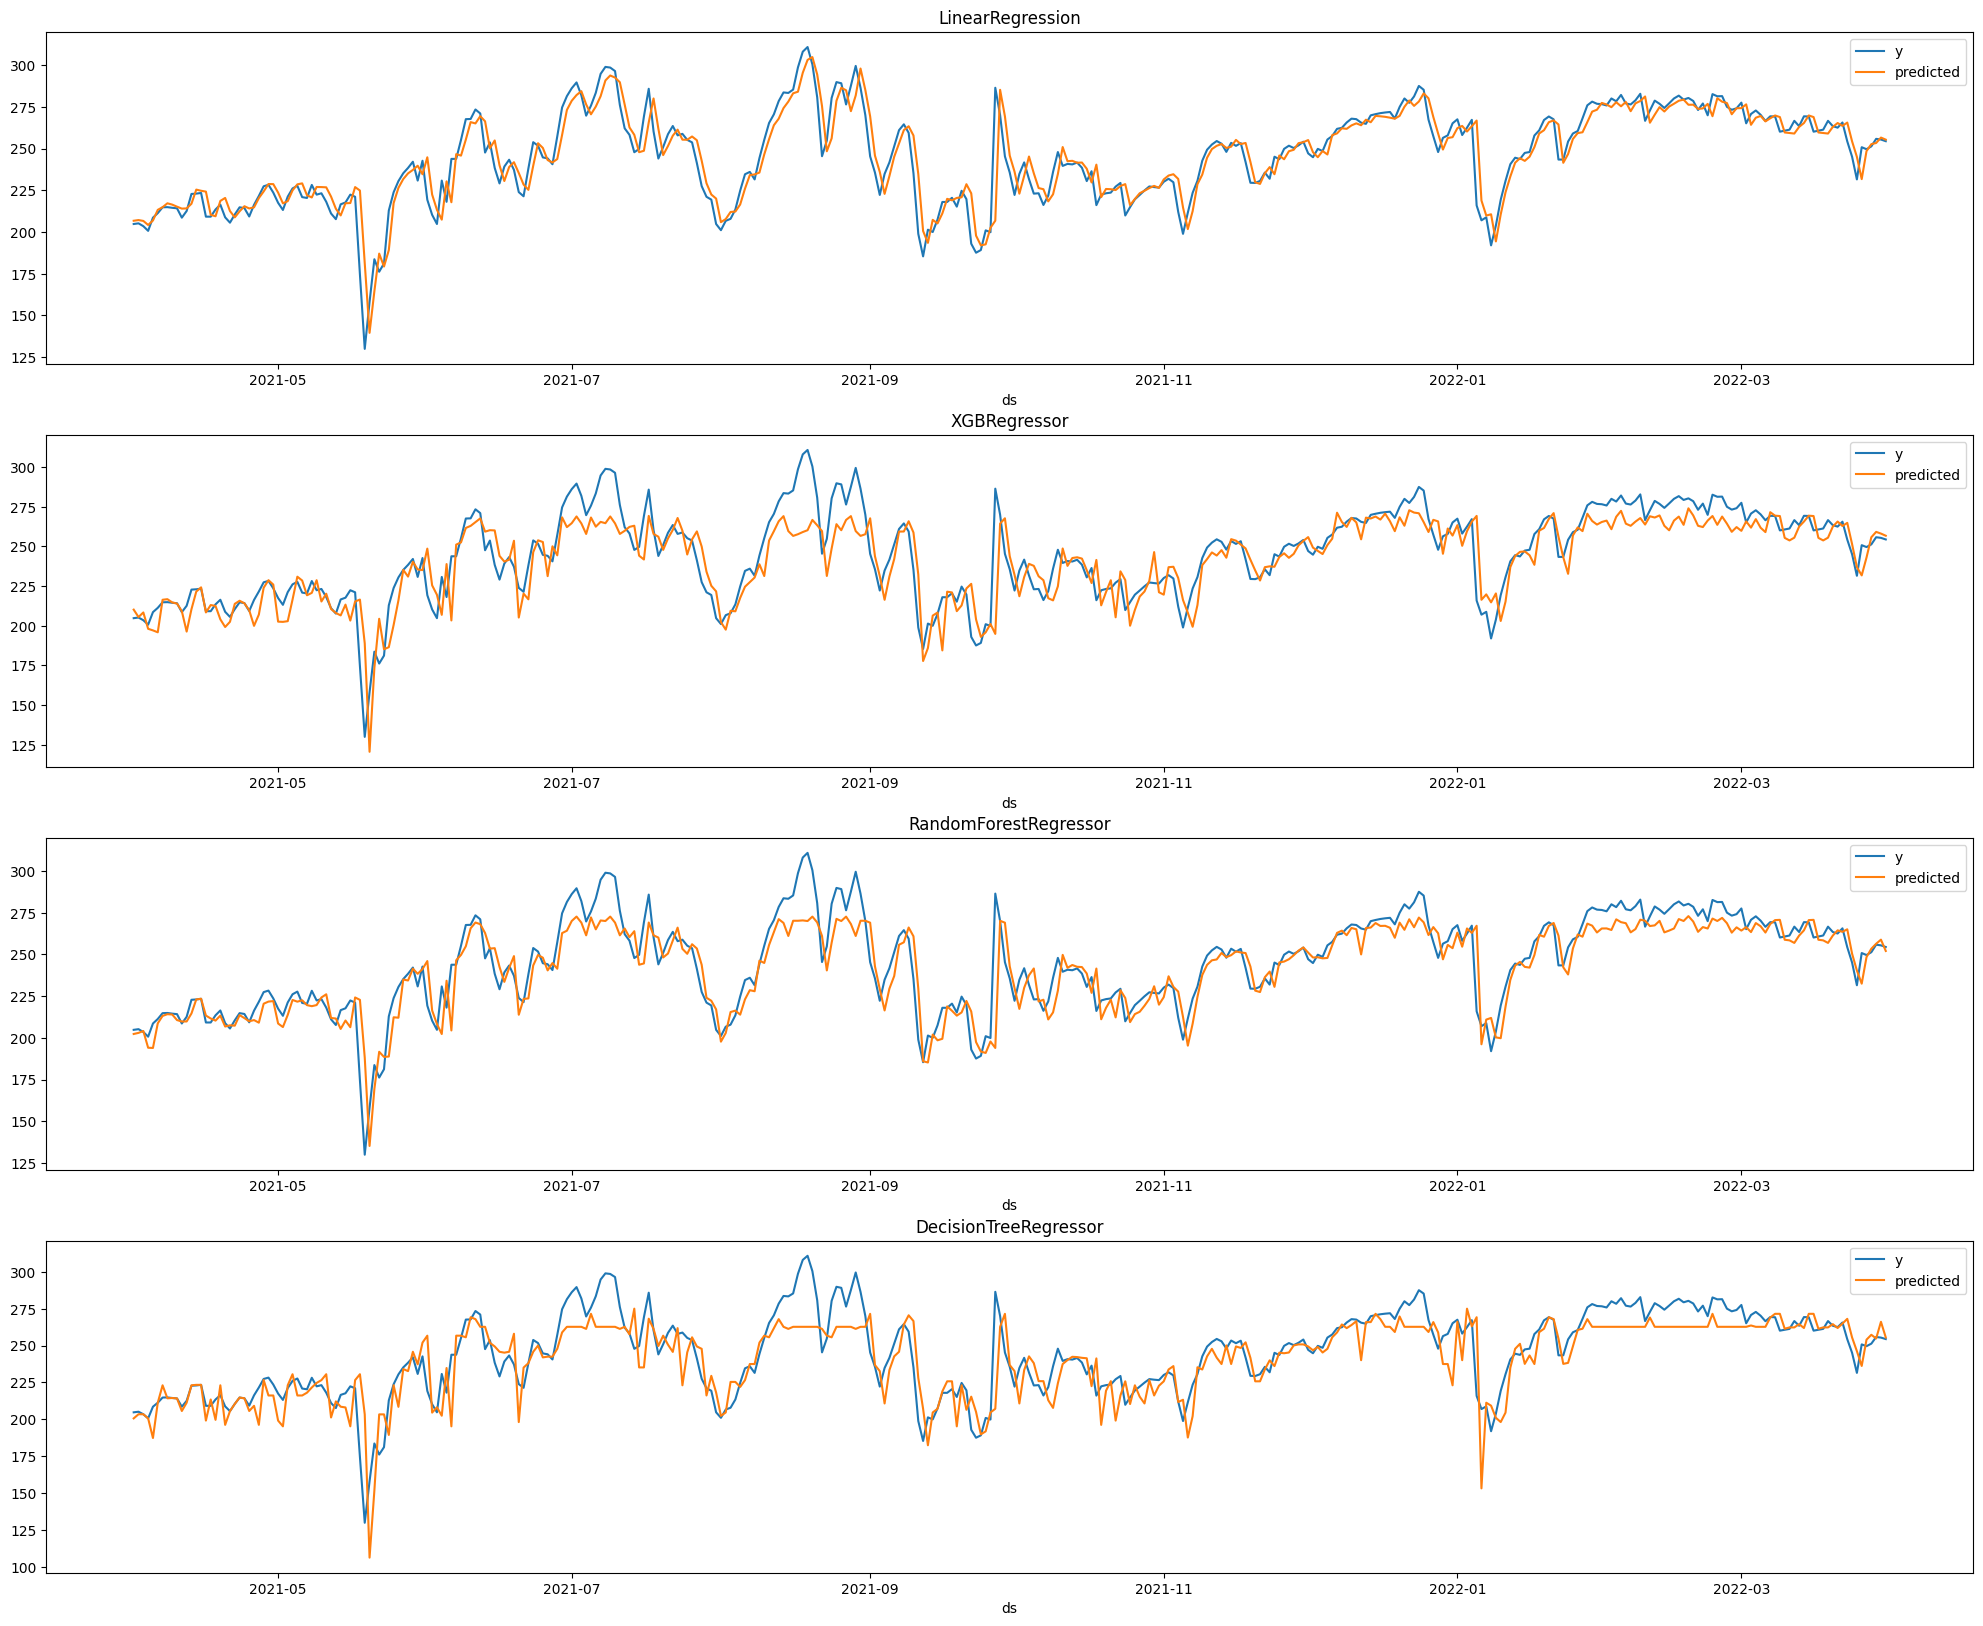

In [116]:
rajML.plot_predictions("rajML")

ML models on Delhi data

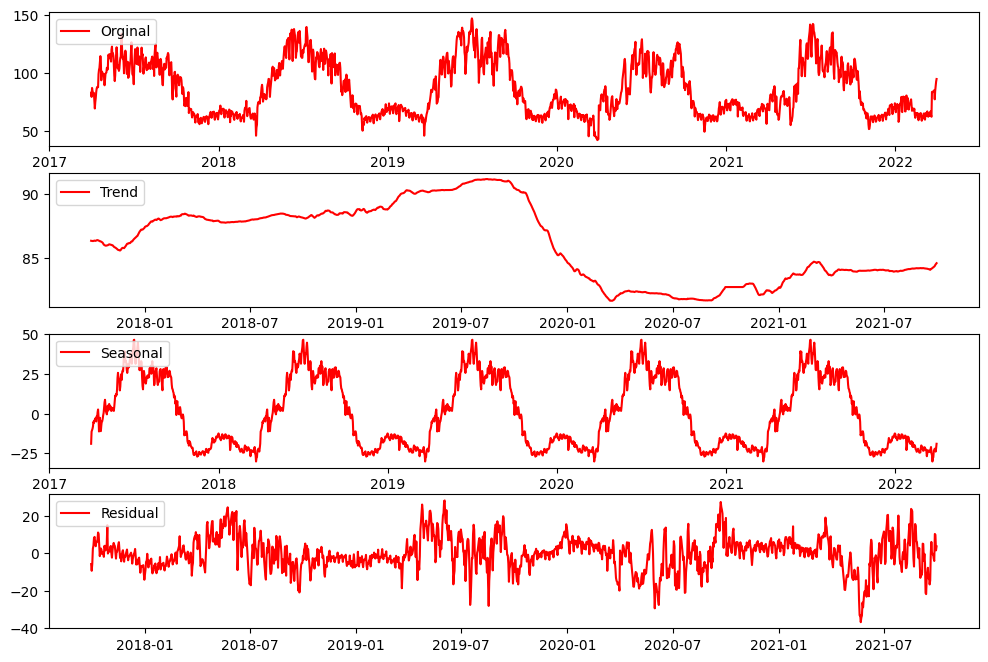

In [117]:
delML.plotter("delSD.jpg")

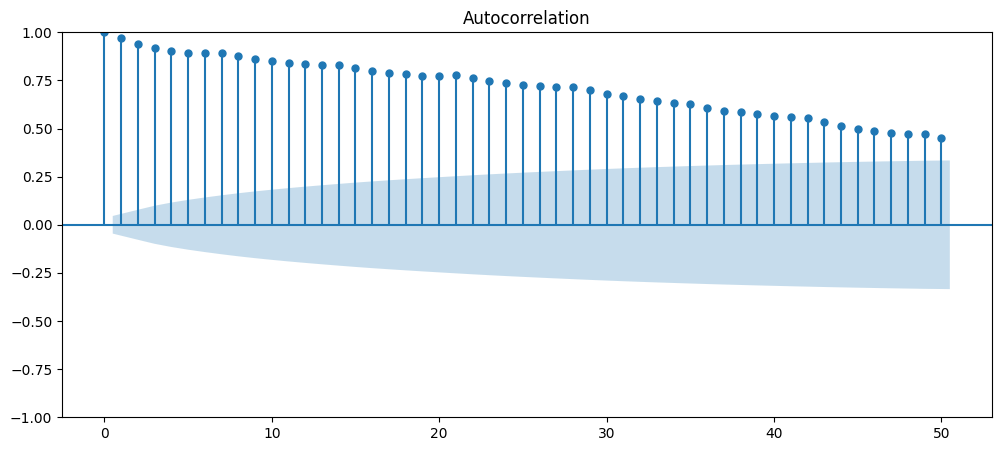

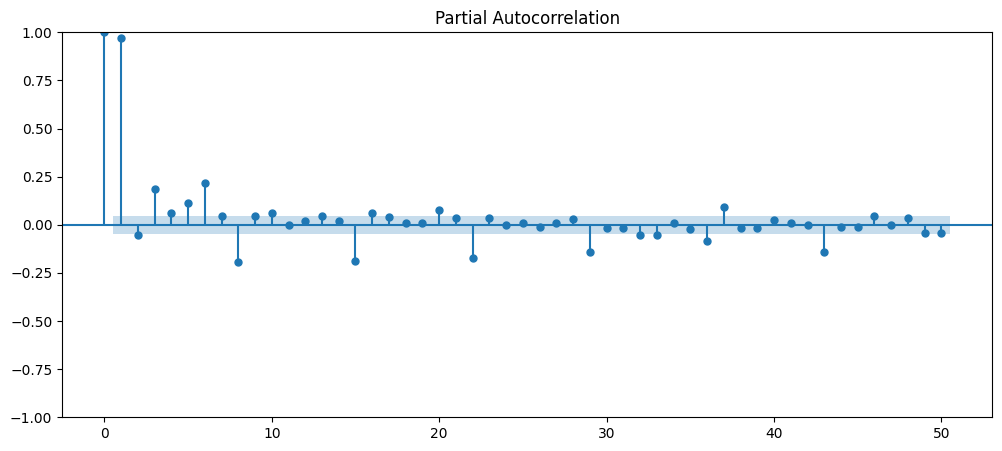

In [118]:
delML.plot_corr("del")

In [119]:
delML.add_lag(1)
delML.add_lag(6)
delML.train()

<ipython-input-93-f352f3d1ff34>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[f'lag_'+str(lag)]=self.df[self.y_var].shift(lag)
<ipython-input-93-f352f3d1ff34>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.dropna(inplace=True)
<ipython-input-93-f352f3d1ff34>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

--------------------------------------------------
Fitting LinearRegression done
--------------------------------------------------
Fitting XGBRegressor done
--------------------------------------------------
Fitting RandomForestRegressor done
--------------------------------------------------
Fitting DecisionTreeRegressor done
--------------------------------------------------


In [120]:
delML.show_result()

R2 Score  Mean Absolute Error Score  \
RandomForestRegressor  0.945786                   3.502110   
LinearRegression       0.942125                   3.724431   
XGBRegressor           0.933630                   3.964820   
DecisionTreeRegressor  0.909446                   4.553297   

                       Mean Squared Error Score  Root Mean Squared Error  
RandomForestRegressor                 26.545311                 5.152214  
LinearRegression                      28.337958                 5.323341  
XGBRegressor                          32.497853                 5.700689  
DecisionTreeRegressor                 44.339176                 6.658767

<Figure size 1200x800 with 0 Axes>

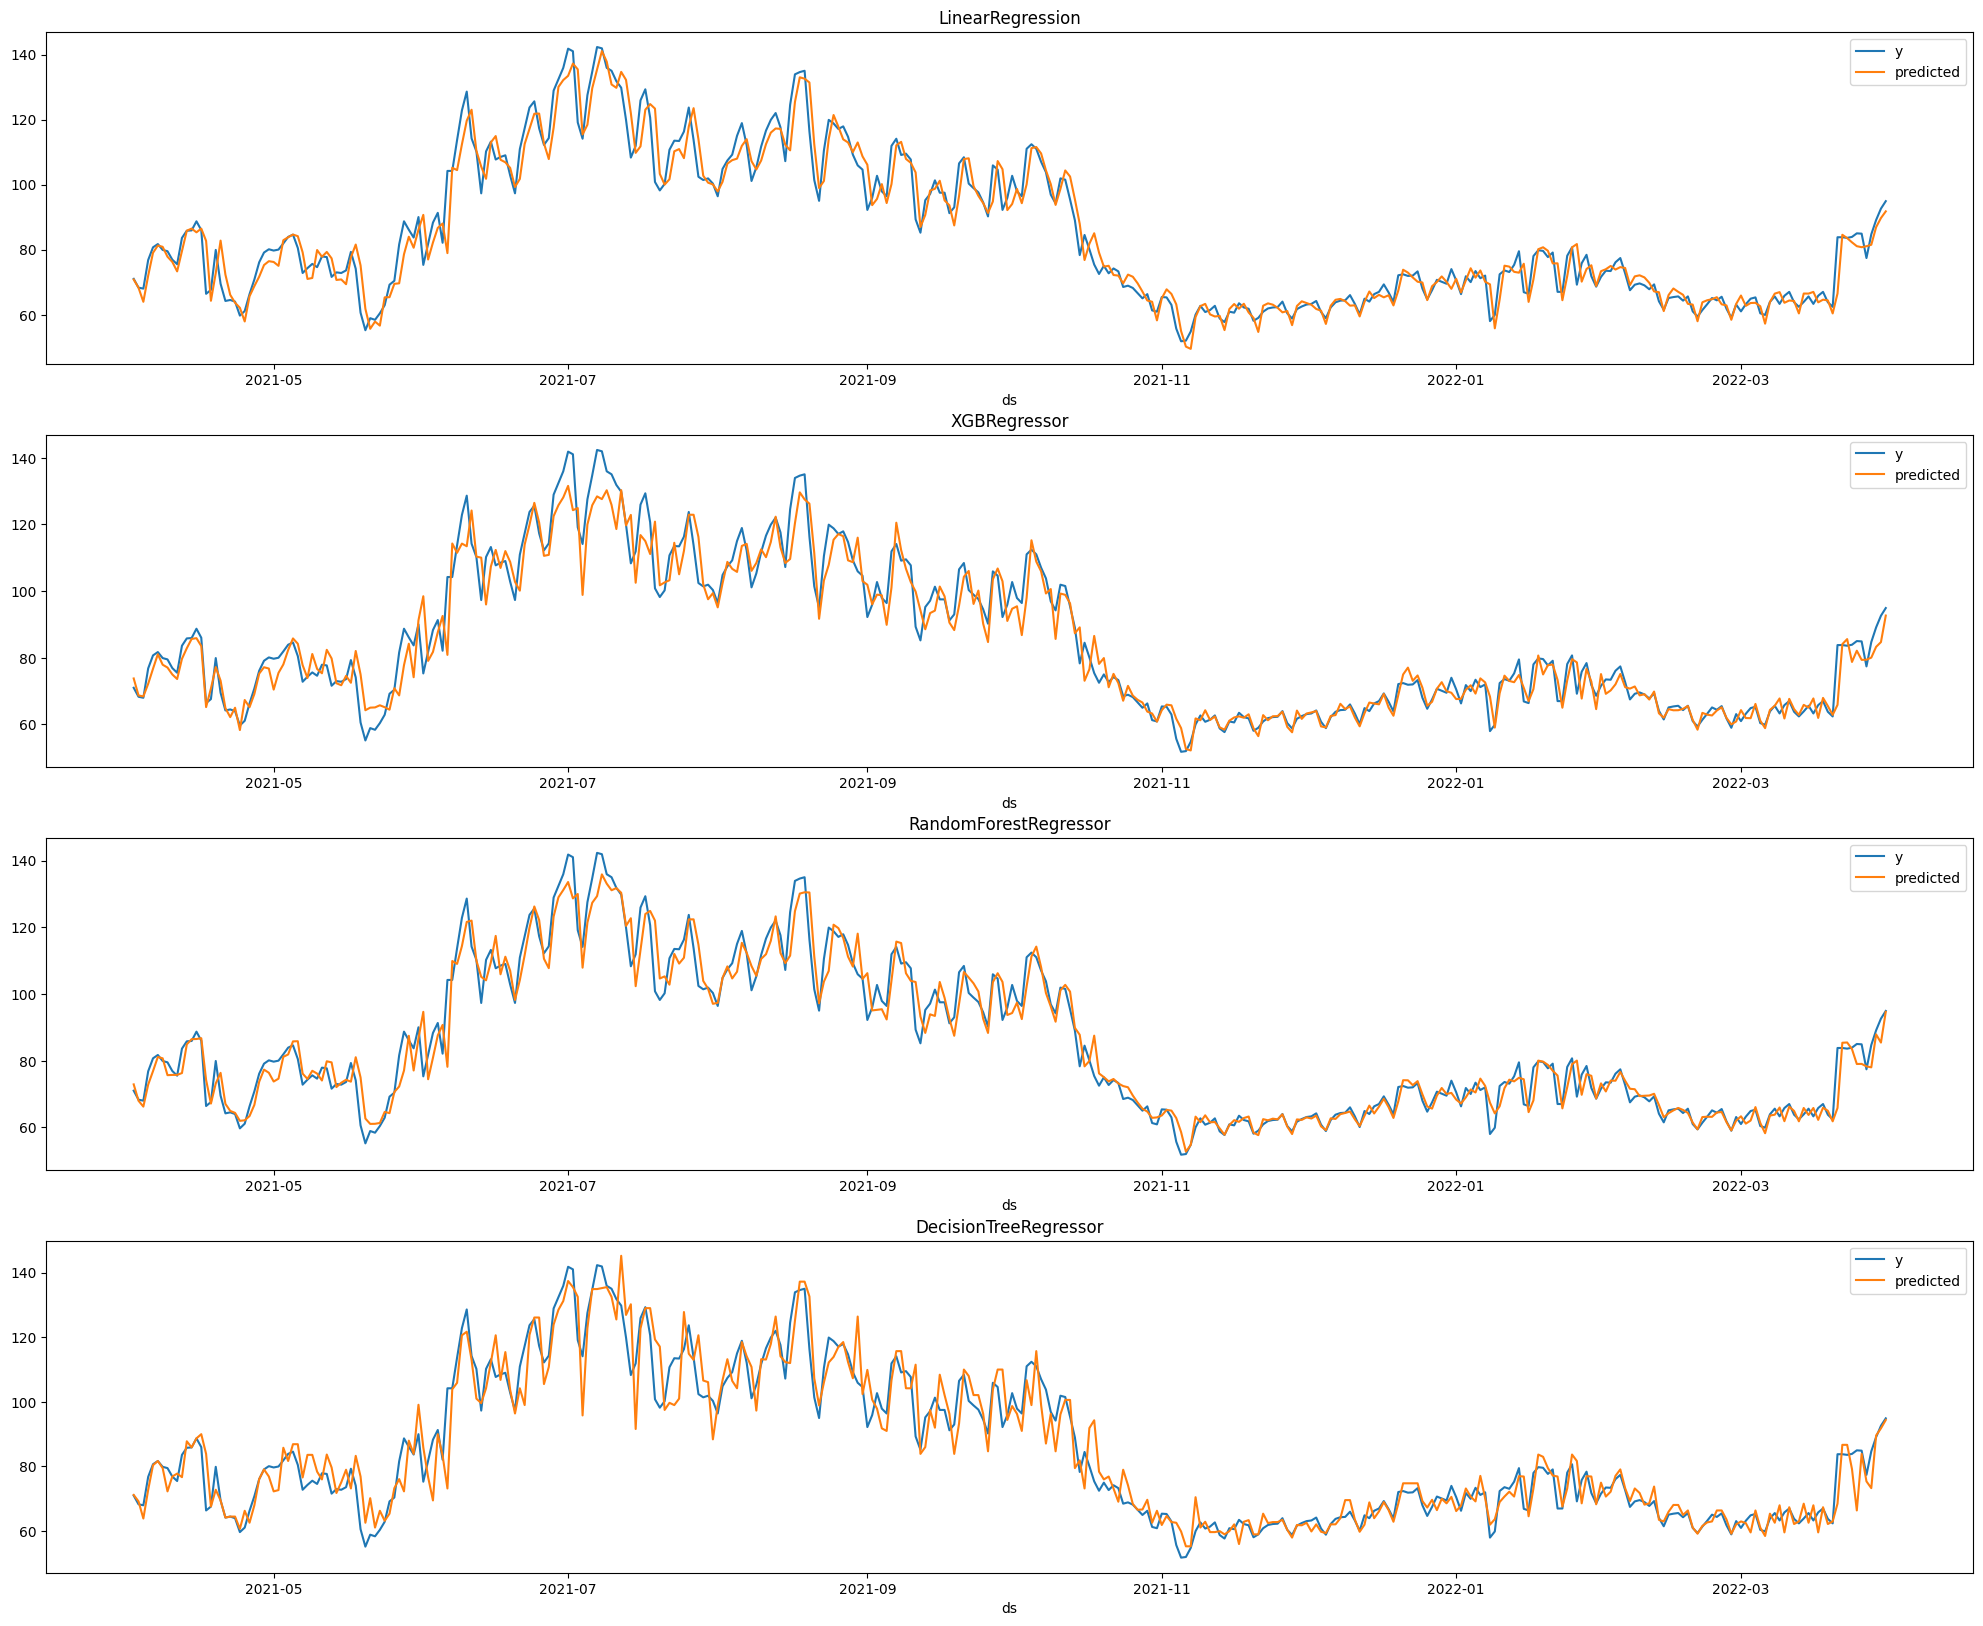

In [121]:
delML.plot_predictions("delML")

ML models on UP data

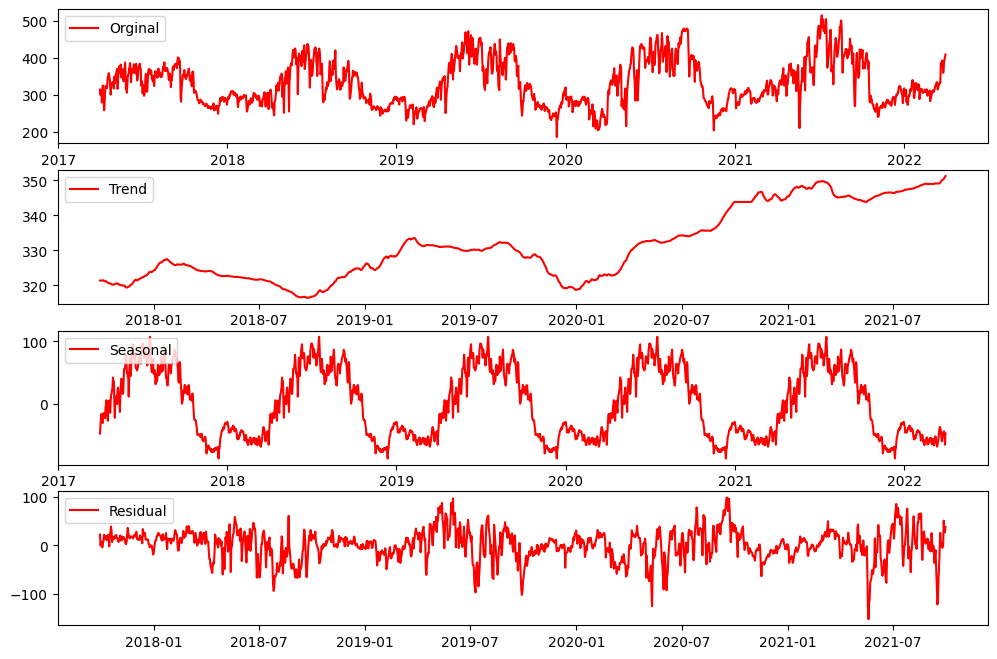

In [122]:
upML.plotter("upSD.jpg")

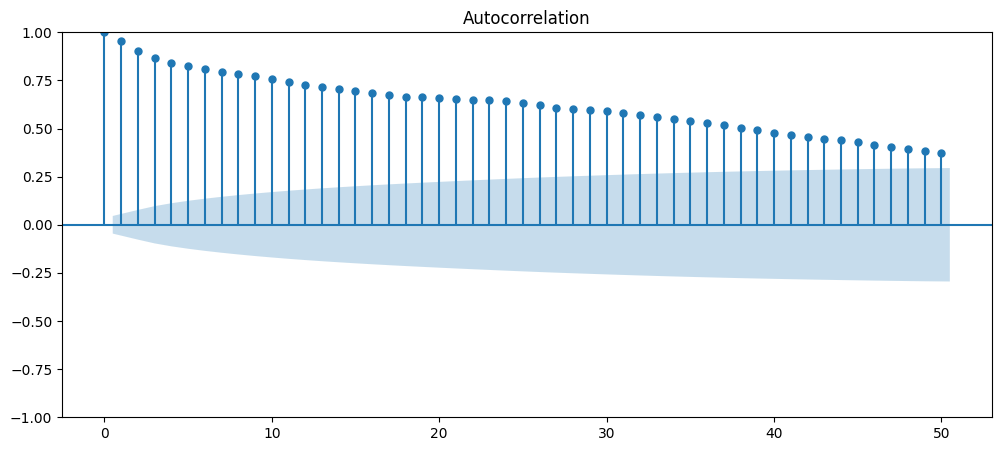

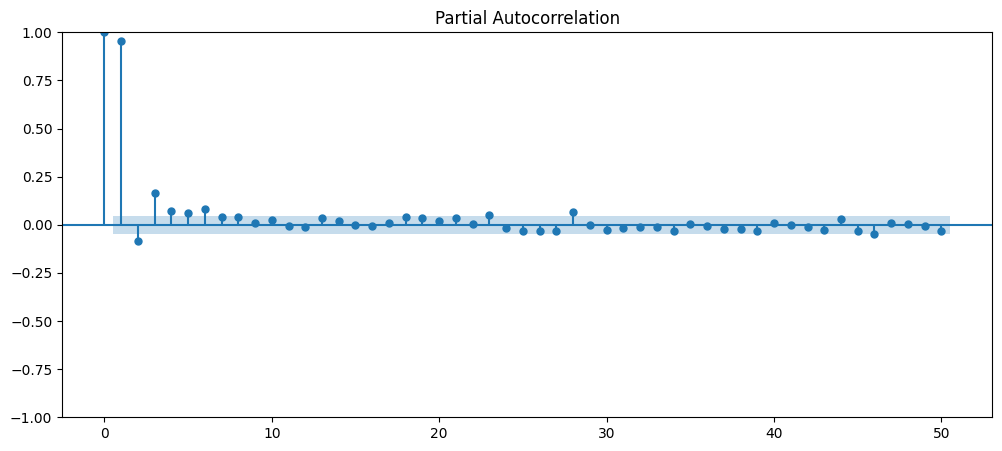

In [123]:
upML.plot_corr("up")

In [124]:
upML.add_lag(1)
upML.train()

<ipython-input-93-f352f3d1ff34>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[f'lag_'+str(lag)]=self.df[self.y_var].shift(lag)
<ipython-input-93-f352f3d1ff34>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.dropna(inplace=True)
<ipython-input-93-f352f3d1ff34>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

--------------------------------------------------
Fitting LinearRegression done
--------------------------------------------------
Fitting XGBRegressor done
--------------------------------------------------
Fitting RandomForestRegressor done
--------------------------------------------------
Fitting DecisionTreeRegressor done
--------------------------------------------------


In [125]:
upML.show_result()

R2 Score  Mean Absolute Error Score  \
LinearRegression       0.895529                  13.861977   
RandomForestRegressor  0.865525                  15.982209   
XGBRegressor           0.850986                  17.060091   
DecisionTreeRegressor  0.738228                  22.492055   

                       Mean Squared Error Score  Root Mean Squared Error  
LinearRegression                     412.936624                20.320842  
RandomForestRegressor                531.529715                23.054928  
XGBRegressor                         588.998406                24.269289  
DecisionTreeRegressor               1034.687068                32.166552

<Figure size 1200x800 with 0 Axes>

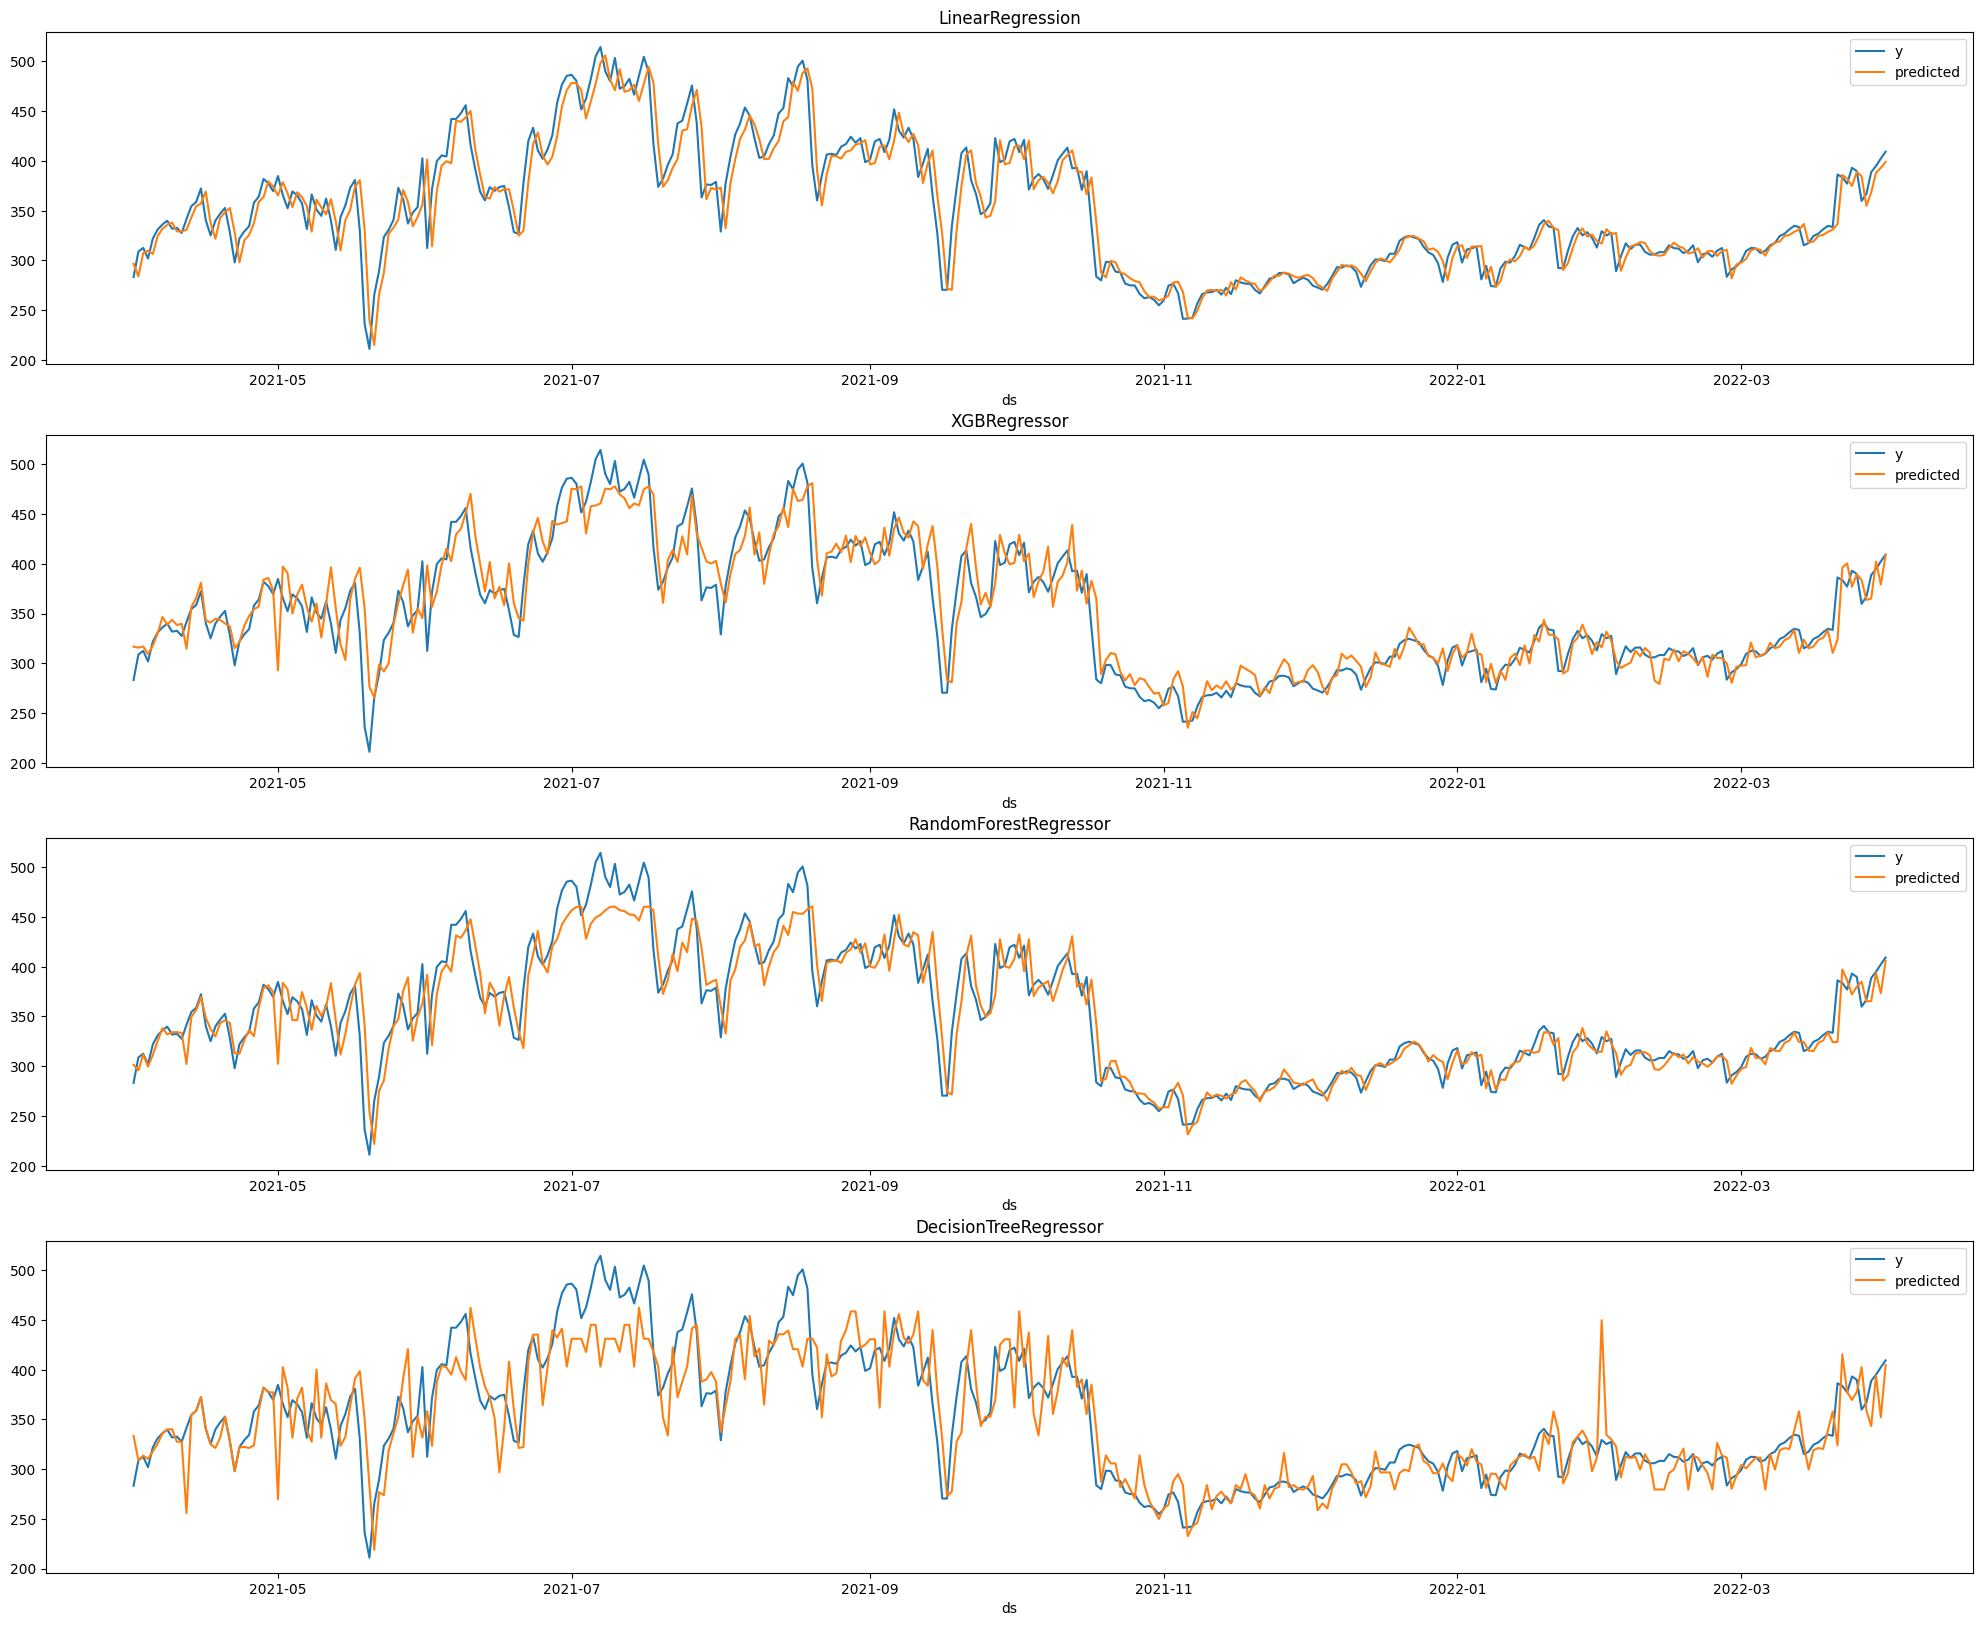

In [126]:
upML.plot_predictions("upML")

In [127]:
final_result = dict()

In [128]:

results = dict()
def averages():
  datas = [indML,pnbML,hryML,rajML,delML,upML]
  models = ["LinearRegression","RandomForestRegressor","XGBRegressor","DecisionTreeRegressor"]
  parameters = ["R2 Score","Mean Absolute Error Score","Mean Squared Error Score","Root Mean Squared Error"]
  for model in models:
    sum = 0
    results[model] = {}
    for para in parameters:
      for data in datas:
        sum += data.result[model][para]
      results[model][para] = sum/6
  # final_result = results
  score_pd=pd.DataFrame(results).transpose().sort_values("R2 Score",ascending=False)
  return score_pd

In [129]:
reg = averages()
reg

R2 Score  Mean Absolute Error Score  \
LinearRegression       0.913105                  17.517519   
RandomForestRegressor  0.873107                  22.549906   
XGBRegressor           0.841401                  25.096146   
DecisionTreeRegressor  0.786229                  28.519653   

                       Mean Squared Error Score  Root Mean Squared Error  
LinearRegression                    1161.490472              1184.760070  
RandomForestRegressor               2683.152757              2715.232397  
XGBRegressor                        3543.508423              3579.814006  
DecisionTreeRegressor               4314.743574              4355.935052

**Deep Learning Model**


In [130]:
import numpy as np
class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(self,data: pd.DataFrame,Y_var: str,lag: int,LSTM_layer_depth: int,epochs=10,batch_size=256,train_test_split=0):
        self.data = data
        self.Y_var = Y_var
        self.lag = lag
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split
        self.result = {}

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of
        deep learning models
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        return X, Y

    def create_data_for_NN(self,use_last_n=None):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]

            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model
        """
        # Getting the data
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(100))
        model.add(Dense(64))
        model.add(Dense(32))
        model.compile(optimizer='adam', loss='mse')

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

        # Defining the model parameter dict
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False,
            'callbacks':[es]
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model
        model.fit(
            **keras_dict
        )

        # Saving the model to the class
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):

            # Getting the last n time series
            _, X_test, _, _ = self.create_data_for_NN()

            # Making the prediction list
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def plot_predictions(self,fig_name,fc):
      plt.figure(figsize=(12,8))

      i = 0
      fig,ax1=plt.subplots(figsize=(12,5))
      pred=fc['forecast']
      sns.lineplot(data=fc.y,ax=ax1,legend='brief',label="actual")
      sns.lineplot(y=pred,x=fc.y.index,ax=ax1,legend="brief",label="predicted")
      ax1.set_title("LSTM")
      plt.savefig(str(fig_name+"LSTM.jpg"))
      plt.show()

    def show_results(self,fig_name):
      pred = self.predict()
      fc = self.data.tail(len(pred)).copy()
      # fc.reset_index(inplace=True)
      fc['forecast'] = pred
      self.plot_predictions(fig_name,fc)
      self.result = {
          "R2 Score" : r2_score(fc['y'],fc['forecast']),
          "Mean Absolute Error Score" : mean_absolute_error(fc['y'],fc['forecast']),
          "Mean Squared Error Score" : mean_squared_error(fc['y'],fc['forecast']),
          "Root Mean Squared Error": mean_squared_error(fc['y'],fc['forecast'], squared=False)
      }

      # score=pd.DataFrame(self.result).transpose().sort_values("R2 Score",ascending=False)
      return self.result

In [131]:
deep_ind = DeepModelTS(data = df_ind,Y_var = 'y',lag = 8,LSTM_layer_depth = 100,epochs = 100,batch_size = 256,train_test_split = 0.2)
deep_pnb = DeepModelTS(data = df_pnb,Y_var = 'y',lag = 1,LSTM_layer_depth = 100,epochs = 100,batch_size = 256,train_test_split = 0.2)
deep_hry = DeepModelTS(data = df_hry,Y_var = 'y',lag = 1,LSTM_layer_depth = 100,epochs = 100,batch_size = 256,train_test_split = 0.2)
deep_raj = DeepModelTS(data = df_raj,Y_var = 'y',lag = 1,LSTM_layer_depth = 100,epochs = 100,batch_size = 256,train_test_split = 0.2)
deep_del = DeepModelTS(data = df_del,Y_var = 'y',lag = 6,LSTM_layer_depth = 100,epochs = 100,batch_size = 256,train_test_split = 0.2)
deep_up = DeepModelTS(data = df_up,Y_var = 'y',lag = 1,LSTM_layer_depth = 100,epochs = 100,batch_size = 256,train_test_split = 0.2)

In [ ]:
print('-'*50)
model_ind = deep_ind.LSTModel()
print('-'*50)
model_pnb = deep_pnb.LSTModel()
print('-'*50)
model_hry = deep_hry.LSTModel()
print('-'*50)
model_raj = deep_raj.LSTModel()
print('-'*50)
model_del = deep_del.LSTModel()
print('-'*50)
model_up = deep_up.LSTModel()
print('-'*50)

--------------------------------------------------
Epoch 1/100
6/6 [==============================] - 2s 91ms/step - loss: 12058955.0000 - val_loss: 11944734.0000
Epoch 2/100
6/6 [==============================] - 0s 37ms/step - loss: 8511648.0000 - val_loss: 7031301.5000
Epoch 3/100
6/6 [==============================] - 0s 39ms/step - loss: 4306474.0000 - val_loss: 3067024.2500
Epoch 4/100
6/6 [==============================] - 0s 38ms/step - loss: 1950066.8750 - val_loss: 850113.9375
Epoch 5/100
6/6 [==============================] - 0s 35ms/step - loss: 414989.7188 - val_loss: 242364.8125
Epoch 6/100
6/6 [==============================] - 0s 39ms/step - loss: 244800.9062 - val_loss: 200207.1406
Epoch 7/100
6/6 [==============================] - 0s 37ms/step - loss: 172297.5781 - val_loss: 166457.8125
Epoch 8/100
6/6 [==============================] - 0s 36ms/step - loss: 144534.2500 - val_loss: 170173.9844
Epoch 9/100
6/6 [==============================] - 0s 38ms/step - loss: 1149

In [ ]:
res_ind = deep_ind.show_results("ind")

In [ ]:
res_pnb = deep_pnb.show_results("pnb")

In [ ]:
res_hry = deep_hry.show_results("hry")

In [ ]:
res_raj = deep_raj.show_results("raj")

In [ ]:
res_del = deep_del.show_results("del")

In [ ]:
res_up = deep_up.show_results("up")

In [ ]:
res_up

In [ ]:
scores = {}
scores['India'] = res_ind
scores['Punjab'] = res_pnb
scores['Haryana'] = res_hry
scores['Rajasthan'] = res_raj
scores['Delhi'] = res_del
scores['UP'] = res_up

In [ ]:
combined = pd.DataFrame.from_dict(scores)
combined

In [ ]:
def deep_average():
  results = [res_ind,res_pnb,res_hry,res_raj,res_del,res_up]
  r2 = 0
  mae = 0
  mse = 0
  rme = 0
  for res in results:
    r2 += res['R2 Score']
    mae += res['Mean Absolute Error Score']
    mse += res['Mean Squared Error Score']
    rme += res['Root Mean Squared Error']
  score = {'R2 Score': r2/6,
  'Mean Absolute Error Score': mae/6,
  'Mean Squared Error Score': mse/6,
  'Root Mean Squared Error': rme/6}
  return score

In [ ]:
lstm = deep_average()

In [ ]:
results

In [ ]:
results["LSTM"] = lstm
score_pd=pd.DataFrame(results).transpose().sort_values("R2 Score",ascending=False)
score_pd

In [ ]:
ind = indML.result
ind["LSTM"] = res_ind
score_ind=pd.DataFrame(ind).transpose().sort_values("R2 Score",ascending=False)
score_ind

In [ ]:
pnb = pnbML.result
pnb["LSTM"] = res_pnb
score_pnb=pd.DataFrame(pnb).transpose().sort_values("R2 Score",ascending=False)
score_pnb

In [ ]:
hry = hryML.result
hry["LSTM"] = res_hry
score_hry=pd.DataFrame(hry).transpose().sort_values("R2 Score",ascending=False)
score_hry

In [ ]:
raj = rajML.result
raj["LSTM"] = res_raj
score_raj=pd.DataFrame(raj).transpose().sort_values("R2 Score",ascending=False)
score_raj

In [ ]:
delhi = delML.result
delhi["LSTM"] = res_del
score_del=pd.DataFrame(delhi).transpose().sort_values("R2 Score",ascending=False)
score_del

In [ ]:
up = upML.result
up["LSTM"] = res_up
score_up=pd.DataFrame(up).transpose().sort_values("R2 Score",ascending=False)
score_up